In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
from sklearn.linear_model import LinearRegression
np.random.seed(0)

In [2]:
import keras 
import tensorflow as tf
from keras.datasets import cifar10
from keras.callbacks import History 
#using tensorflow backend

Using TensorFlow backend.


In [3]:
def mse_custom(y_true,y_predicted):
    mse_mod = tf.math.reduce_mean(tf.math.abs(tf.subtract(y_true[3:-3],y_predicted[3:-3])))
    return mse_mod

In [4]:
def new_cases_per_day(fecha_sintomas,graph=False,ret=False):
    """
    args: 
    -fecha_sintomas: day of beginning of symptomps for each case, can't be NaN or NaT (already processed)
    -graph: defaults to False. if True, makes graph of new cases per day 
    -ret: defaults to False. if True, returns days-cases per day  np.array casos_por_dia
    given the days of beginning of symptoms, processes to get np.array of cases per day and days since epidemic
    can graph and return this vector with the defaults explained before
    """
    counts = np.bincount(fecha_sintomas)
    ultima_fecha = max(fecha_sintomas)
    aux = range(ultima_fecha+1)
    casos_por_dia = np.vstack((aux,counts[aux])).T #(days since inicio_epidemia x (fecha_inicio_sintomas == days))
    if graph == True:
        plt.xlabel("Dia")
        plt.ylabel("Casos")
        plt.axvspan(ultima_fecha-10, ultima_fecha+3, facecolor='r', alpha=0.5,label="últimos 10 días")
        plt.plot(casos_por_dia[:,0],casos_por_dia[:,1],'-ob',label="casos hasta dia: "+str(ultima_fecha))
        plt.style.use('ggplot')
        plt.legend()
        #plt.savefig("casos_por_dia_bariloche.pdf")
    if ret == True:
        return casos_por_dia   

In [5]:
def cumulative_cases(fecha_sintomas,graph=False,ret=False):
    """
    args: 
    -fecha_sintomas: day of beginning of symptomps for each case, can't be NaN or NaT (already processed)
    -graph: defaults to False. if True, makes graph of new cases per day 
    -ret: defaults to False. if True, returns days-cumulative cases per day np array
    given the days of beginning of symptoms, processes to get np.array of cumulative cases per day and days since epidemic
    can graph and return this vector with the defaults explained before
    """
    ultima_fecha = max(fecha_sintomas)
    casos_por_dia = new_cases_per_day(fecha_sintomas,ret=True)
    casos_acumulados_por_dia = np.copy(casos_por_dia)
    casos_acumulados_por_dia[:,1] = np.cumsum(casos_por_dia[:,1]) 
    if graph == True:
        plt.xlabel("Dia")
        plt.ylabel("Casos acumulados")
        plt.axvspan(ultima_fecha-10, ultima_fecha+3, facecolor='r', alpha=0.5,label="últimos 10 días")
        plt.scatter(casos_acumulados_por_dia[:,0],casos_acumulados_por_dia[:,1],c='b',label="casos acumulados hasta dia: "+str(ultima_fecha))
        plt.legend()
        plt.style.use('ggplot')
        plt.savefig("casos_acumulados_bariloche.pdf")
    if ret == True:
        return casos_acumulados_por_dia   

In [6]:
def repratio_t_conv(fecha_sintomas,a,graph=False,ret=False):
    """
    args: 
    -fecha_sintomas: day of beginning of symptomps for each case, can't be NaN or NaT (already processed)
    -graph: defaults to False. if True, makes graph of rep ratio per day
    -ret: defaults to False. if True, returns reproductive ratio per day np array of (days,r_days) and
    the n_t vector which is used to calculate it, which is extension of new cases per day made as 
    necessary, by taking means and not linear regression. 
    given the days of beginning of symptoms, processes to get np.array of cumulative cases per day and days since epidemic
    can graph and return this vector with the defaults explained before for days (0,lastday+4)
    conventional version, which means no coef a,b,c,d,e. r_t valid for days >= 6. 
    """
    casos_por_dia = new_cases_per_day(fecha_sintomas,ret=True)
    n_t = np.copy(casos_por_dia) #here we store data + proyection for days t+4 
    prox_dia = max(fecha_sintomas) + 1
    #completing the values for the rest of the values of n_t
    aux = np.zeros(2)
    i = 0
    while i < 4: #completing until the day t+4 bc im gonna need it later for averaging in 7 days
        aux[0] = prox_dia + i
        aux[1] = np.mean(n_t[prox_dia-7:,1])
        n_t  = np.vstack((n_t,aux)) #extending n_t up to day t+1
        i= i +1
    #create storage and calculate values for r_t
    r_t = np.copy(n_t) #here we will store the rt
    r_t = r_t.astype(float)
    dias_aux = np.arange(0,prox_dia+3)
    for i in dias_aux[dias_aux>=6]:
        aux = a[0]*n_t[i-6,1] + a[1]*n_t[i-5,1] + a[2]*n_t[i-4,1] #denominator of the r_t expression
        if(aux==0):
            aux = 1 #the first cases in which the denominator is == 0
        r_t[i,1] = min(((a[3]*n_t[i-1,1] + a[4]*n_t[i,1] + a[5]*n_t[i+1,1])/(aux)),4) #the rest of the days with limit value
    if graph == True:
        plt.style.use('ggplot')
        plt.axvspan(prox_dia-10, prox_dia+3, facecolor='r', alpha=0.5,label="últimos 10 días")
        plt.scatter(r_t[6:prox_dia,0],r_t[6:prox_dia,1],c='b',label=r'$r_t$')
        plt.xlabel("Dia")
        plt.ylabel(r'$r_t$',fontsize=12)
        plt.legend()
        plt.savefig("rt_raw_casos.pdf")
    if ret == True:
        return n_t,r_t

In [7]:
def risk_diagram(fecha_sintomas,pop,a,rep_fun=repratio_t_conv,graph=False,ret=False):
    """
    args: 
    -fecha_sintomas: day of beginning of symptomps for each case, can't be NaN or NaT (already processed)
    -pop: number of inhabitants of the region/population of interest
    -rep_fun: function to calculate empirical reproductive ratio. defaults tp repratio_t_conv (not optimized)
    -graph: defaults to False. if True, makes graph of risk diagram
    -ret: defaults to False. if True, returns the components of risk diagram in two np.arrays, which are
     the attack ratio (days>=20) as well as the rep ratio averaged over 7 days (days>=20). 
    """
    #we proceed to calculate what makes a risk diagram then
    #first, we will calculate r_t average in 7 days
    prox_dia = max(fecha_sintomas) + 1
    n_t,r_t = rep_fun(fecha_sintomas,a,False,True)
    r_t_seven = np.zeros(prox_dia) #real values for index>=9
    a_t = np.zeros(prox_dia) #real values for index >= 13
    i = 9
    while i < prox_dia:
        r_t_seven[i] = np.mean(r_t[i-3:i+4,1])
        i = i+1
    i = 13
    while i < prox_dia:
        a_t[i] = np.sum(n_t[i-13:i+1,1]) 
        i = i+1
    a_t = a_t * (100000/pop)
    if graph == True:
        plt.plot(a_t[13:],r_t_seven[13:],'-or',markersize=5) #not at all fancy risk diagram,looks reasonable
        plt.xlabel(r'$A_{t}^{14}$')
        plt.ylabel(r'$R_{t}^{7}$')
        plt.style.use('ggplot')
        plt.title('Diagrama de riesgo Bariloche',fontsize=10)
        plt.savefig('riskdiagram_brc.pdf')
    if ret == True:
        return r_t_seven,a_t

In [8]:
def sum_last14(casos_por_dia):
    ac_por_dia = np.copy(casos_por_dia)
    for i in casos_por_dia[:,0]:
        index = np.copy(casos_por_dia[casos_por_dia[:,0]<i+1])
        index = index[i-13<=index[:,0]]
        index = index[:,1]
        ac_por_dia[i,1] = np.sum(index) 
    return ac_por_dia

In [9]:
def predict_cases(fecha_sintomas,pop,a,rep_fun=repratio_t_conv,graph=False,ret=False):
    """
    args: 
    -fecha_sintomas: day of beginning of symptomps for each case, can't be NaN or NaT (already processed)
    -pop: number of inhabitants of the region/population of interest
    -rep_fun: function to calculate empirical reproductive ratio. defaults tp repratio_t_conv (not optimized)
    -graph: defaults to False. if True, makes graph of risk diagram
    -ret: defaults to False. if True, returns the predictions and cases per day
    predicts cases per day after calculating the risk diagram, using the empirical reproductive
    ratio given by rep_fun
    """
    prox_dia = max(fecha_sintomas)+1
    casos_por_dia = new_cases_per_day(fecha_sintomas,ret=True)
    r_def,a_t = risk_diagram(fecha_sintomas,pop,a,rep_fun,ret=True)
    r_def = r_def[13:]
    a_t = a_t[13:]
    p_t = r_def * a_t
    valid_days = np.arange(19,prox_dia+6,1)
    casos_por_dia = sum_last14(casos_por_dia) #gets all active cases in the last 14-days 
    if graph == True:
        plt.style.use('ggplot')
        plt.xlabel('Dias desde el comienzo')
        plt.ylabel('Infectados activos en BRC')
        plt.plot(casos_por_dia[:,0],casos_por_dia[:,1]*(100000/pop),'-ob',markersize=4,label="casos hasta dia: "+str(prox_dia))
        plt.plot(valid_days,p_t,linewidth=3,label='prediccion')
        plt.legend()
        #plt.savefig('9oct_predic_casos.pdf')
    if ret == True:
        error_global = np.linalg.norm(casos_por_dia[19:,1]-p_t[:-6])
        return error_global

In [10]:
def change_dates(df):
    #changes fecha_inicio_sintomas according to new criteria
    filt_df1 = (df.fecha_inicio_sintomas.isnull()) #filter fecha_inicio_sintomas = inexistant
    df_sin_fecha = df.loc[filt_df1]
    n_size = df_sin_fecha.shape[0]
    df.loc[filt_df1,"fecha_inicio_sintomas"] = df.loc[filt_df1,"fecha_apertura"] - np.random.randint(0,9,n_size)
    filt_df2 = (df.fecha_inicio_sintomas < 0)
    df[filt_df2] = 0

In [11]:
data = pd.read_csv("casos/CasosCovid19_arg.txt",sep=",",quotechar='"',
                   parse_dates=["fecha_inicio_sintomas","fecha_apertura"],na_values=['']) #data loading
df = pd.DataFrame(data) #converting to dataframe for use

In [12]:
filt_df1 = (df.fecha_inicio_sintomas.notnull()) #filter fecha_inicio_sintomas = inexistant
inicio_epidemia = min(df.loc[filt_df1,"fecha_inicio_sintomas"]) #first symptoms of a person registered
ultima_actualizacion_sintomas = max(df.loc[filt_df1,"fecha_inicio_sintomas"]) #last day symptoms of a person registered
ultima_actualizacion_apertura = max(df["fecha_apertura"])
df["fecha_inicio_sintomas"] -= inicio_epidemia #correcting by inicio_epidemia 
df["fecha_apertura"] -= inicio_epidemia #correcting by inicio_epidemia
df.fecha_inicio_sintomas = df.fecha_inicio_sintomas.dt.days #change to int, ditch days 
df.fecha_apertura = df.fecha_apertura.dt.days #change to int, ditch days
change_dates(df) #replaces non existing fecha_inicio_sintomas acc to new criteria
print("primer sintoma de persona confirmada: ",inicio_epidemia)
print("ultimo sintoma de persona confirmada: ",ultima_actualizacion_sintomas)
print("ultima apertura de persona confirmada: ",ultima_actualizacion_apertura)

primer sintoma de persona confirmada:  2020-01-01 00:00:00
ultimo sintoma de persona confirmada:  2020-12-29 00:00:00
ultima apertura de persona confirmada:  2020-12-29 00:00:00


In [13]:
fecha_sintomas = df.fecha_inicio_sintomas.to_numpy() #numpy array of fecha_inicio_sintomas
fecha_apertura = df.fecha_apertura.to_numpy() #numpy array of fecha_apertura
fecha_sintomas = fecha_sintomas.astype(int)

In [14]:
aw = np.zeros(6) + 1
pop = 100000
rep_fun = repratio_t_conv
r_def,a_t = risk_diagram(fecha_sintomas,pop,aw,rep_fun,ret=True) #hasta aca perfecto
a_t = a_t[10:] 
a = a_t[:-4]

In [15]:
casos_por_dia = new_cases_per_day(fecha_sintomas,ret=True)
casos_por_dia = sum_last14(casos_por_dia)
casos_por_dia = casos_por_dia[17:,1]
b = np.zeros(casos_por_dia.shape[0]+3,dtype=float)
b[:casos_por_dia.shape[0]] = casos_por_dia

In [16]:
casos_por_dia = new_cases_per_day(fecha_sintomas,ret=True)
n_t = np.copy(casos_por_dia)
prox_dia = max(fecha_sintomas) + 1
#completing the values for the rest of the values of n_t
aux = np.zeros(2)
i = 0
while i < 4: #completing until the day t+4 bc im gonna need it later for averaging in 7 days
    aux[0] = prox_dia + i
    aux[1] = np.mean(n_t[prox_dia-7:,1])
    n_t  = np.vstack((n_t,aux)) #extending n_t up to day t+1
    i= i +1
dias = np.copy(n_t[:,0]).astype(int)
dias = dias[dias>=10]
dias = dias[dias<=max(fecha_sintomas)-4]
m1 = np.zeros((dias.shape[0],5)) #denominator of r7 expression
m2 = np.zeros((dias.shape[0],3)) #numerator of r7 expression

In [17]:
for i in dias:
    m1[i-10,:] = n_t[i-7:i-2,1]
    m2[i-10,:] = n_t[i-1:i+2,1]

In [18]:
n_dias = m1.shape[0]

In [19]:
def my_matrix(shape):
    m = np.zeros((shape,shape))
    i = 3
    while i < shape-3:
        m[i,i-3:i+4] = 1/7
        i = i + 1
    return m

In [20]:
def ret_matrix(shape):
    numpyA = my_matrix(shape)
    numpyA = keras.backend.variable(numpyA)
    mat = numpyA
    return mat

In [21]:
n_dias = m1.shape[0]

In [22]:
mat = ret_matrix(n_dias)

In [23]:
pop = 45376763 #poblacion en cuestion

In [24]:
input_1 = keras.layers.Input(shape=(5,))
input_2 = keras.layers.Input(shape=(3,))
input_3 = keras.layers.Input(shape=(1,))
initializer = keras.initializers.Ones() #the vector of weights a
l_input_1 = keras.layers.Dense(1,activation='linear',kernel_initializer=initializer,use_bias=False)(input_1)
l_input_2 = keras.layers.Dense(1,activation='linear',use_bias=False,kernel_initializer=initializer,trainable=False)(input_2)
division = keras.layers.Lambda(lambda inputs:  tf.where(inputs[0] != 0, tf.math.minimum(inputs[1]/inputs[0],4), inputs[1]))([l_input_1, l_input_2])#calculates empirical rt
mean = keras.layers.Lambda(lambda x: keras.backend.dot(mat,x))(division) #calculates mean r_seven in seven days
cases = keras.layers.Multiply()([input_3,mean]) #cases for valid prediction,net output, padded with zeros at the end
model = keras.Model(inputs=[input_1,input_2,input_3],outputs=[cases])
optimizer = keras.optimizers.Adam(1e-2)
model.compile(optimizer, loss=mse_custom)
history = model.fit([m1,m2,a*(100000/pop)], b*(100000/pop), epochs=20000, batch_size=n_dias,shuffle=False)
model.summary()

Epoch 1/20000
350/350 [==============================] - 1s 3ms/step - loss: 57.3260
Epoch 2/20000
350/350 [==============================] - 0s 24us/step - loss: 56.4698
Epoch 3/20000
350/350 [==============================] - 0s 0us/step - loss: 55.5958
Epoch 4/20000
350/350 [==============================] - 0s 28us/step - loss: 54.7030
Epoch 5/20000
350/350 [==============================] - 0s 23us/step - loss: 53.7906
Epoch 6/20000
350/350 [==============================] - 0s 36us/step - loss: 52.8575
Epoch 7/20000
350/350 [==============================] - 0s 28us/step - loss: 51.9029
Epoch 8/20000
350/350 [==============================] - 0s 0us/step - loss: 50.9255
Epoch 9/20000
350/350 [==============================] - 0s 0us/step - loss: 49.9242
Epoch 10/20000
350/350 [==============================] - 0s 29us/step - loss: 48.8979
Epoch 11/20000
350/350 [==============================] - 0s 28us/step - loss: 47.8452
Epoch 12/20000
350/350 [==============================] 

Epoch 97/20000
350/350 [==============================] - 0s 30us/step - loss: 4.6931
Epoch 98/20000
350/350 [==============================] - 0s 0us/step - loss: 4.6943
Epoch 99/20000
350/350 [==============================] - 0s 0us/step - loss: 4.6947
Epoch 100/20000
350/350 [==============================] - 0s 30us/step - loss: 4.6944
Epoch 101/20000
350/350 [==============================] - 0s 0us/step - loss: 4.6936
Epoch 102/20000
350/350 [==============================] - 0s 0us/step - loss: 4.6922
Epoch 103/20000
350/350 [==============================] - 0s 0us/step - loss: 4.6903
Epoch 104/20000
350/350 [==============================] - 0s 0us/step - loss: 4.6880
Epoch 105/20000
350/350 [==============================] - 0s 0us/step - loss: 4.6853
Epoch 106/20000
350/350 [==============================] - 0s 28us/step - loss: 4.6823
Epoch 107/20000
350/350 [==============================] - 0s 0us/step - loss: 4.6802
Epoch 108/20000
350/350 [=============================

Epoch 192/20000
350/350 [==============================] - 0s 0us/step - loss: 4.5810
Epoch 193/20000
350/350 [==============================] - 0s 28us/step - loss: 4.5797
Epoch 194/20000
350/350 [==============================] - 0s 23us/step - loss: 4.5783
Epoch 195/20000
350/350 [==============================] - 0s 0us/step - loss: 4.5771
Epoch 196/20000
350/350 [==============================] - 0s 36us/step - loss: 4.5757
Epoch 197/20000
350/350 [==============================] - 0s 0us/step - loss: 4.5743
Epoch 198/20000
350/350 [==============================] - 0s 0us/step - loss: 4.5730
Epoch 199/20000
350/350 [==============================] - 0s 28us/step - loss: 4.5717
Epoch 200/20000
350/350 [==============================] - 0s 0us/step - loss: 4.5703
Epoch 201/20000
350/350 [==============================] - 0s 4us/step - loss: 4.5690
Epoch 202/20000
350/350 [==============================] - 0s 0us/step - loss: 4.5676
Epoch 203/20000
350/350 [=========================

Epoch 287/20000
350/350 [==============================] - 0s 28us/step - loss: 4.4467
Epoch 288/20000
350/350 [==============================] - 0s 30us/step - loss: 4.4452
Epoch 289/20000
350/350 [==============================] - 0s 0us/step - loss: 4.4439
Epoch 290/20000
350/350 [==============================] - 0s 0us/step - loss: 4.4425
Epoch 291/20000
350/350 [==============================] - 0s 29us/step - loss: 4.4411
Epoch 292/20000
350/350 [==============================] - 0s 29us/step - loss: 4.4397
Epoch 293/20000
350/350 [==============================] - 0s 27us/step - loss: 4.4383
Epoch 294/20000
350/350 [==============================] - 0s 0us/step - loss: 4.4369
Epoch 295/20000
350/350 [==============================] - 0s 29us/step - loss: 4.4355
Epoch 296/20000
350/350 [==============================] - 0s 15us/step - loss: 4.4342
Epoch 297/20000
350/350 [==============================] - 0s 0us/step - loss: 4.4328
Epoch 298/20000
350/350 [======================

Epoch 382/20000
350/350 [==============================] - 0s 0us/step - loss: 4.3182
Epoch 383/20000
350/350 [==============================] - 0s 29us/step - loss: 4.3169
Epoch 384/20000
350/350 [==============================] - 0s 0us/step - loss: 4.3156
Epoch 385/20000
350/350 [==============================] - 0s 0us/step - loss: 4.3142
Epoch 386/20000
350/350 [==============================] - 0s 0us/step - loss: 4.3129
Epoch 387/20000
350/350 [==============================] - 0s 29us/step - loss: 4.3116
Epoch 388/20000
350/350 [==============================] - 0s 27us/step - loss: 4.3102
Epoch 389/20000
350/350 [==============================] - 0s 0us/step - loss: 4.3089
Epoch 390/20000
350/350 [==============================] - 0s 29us/step - loss: 4.3076
Epoch 391/20000
350/350 [==============================] - 0s 28us/step - loss: 4.3063
Epoch 392/20000
350/350 [==============================] - 0s 0us/step - loss: 4.3050
Epoch 393/20000
350/350 [========================

Epoch 477/20000
350/350 [==============================] - 0s 0us/step - loss: 4.1982
Epoch 478/20000
350/350 [==============================] - 0s 23us/step - loss: 4.1970
Epoch 479/20000
350/350 [==============================] - 0s 35us/step - loss: 4.1958
Epoch 480/20000
350/350 [==============================] - 0s 27us/step - loss: 4.1945
Epoch 481/20000
350/350 [==============================] - 0s 0us/step - loss: 4.1934
Epoch 482/20000
350/350 [==============================] - 0s 29us/step - loss: 4.1921
Epoch 483/20000
350/350 [==============================] - 0s 28us/step - loss: 4.1909
Epoch 484/20000
350/350 [==============================] - 0s 0us/step - loss: 4.1897
Epoch 485/20000
350/350 [==============================] - 0s 0us/step - loss: 4.1885
Epoch 486/20000
350/350 [==============================] - 0s 0us/step - loss: 4.1872
Epoch 487/20000
350/350 [==============================] - 0s 27us/step - loss: 4.1860
Epoch 488/20000
350/350 [=======================

Epoch 572/20000
350/350 [==============================] - 0s 0us/step - loss: 4.1015
Epoch 573/20000
350/350 [==============================] - 0s 0us/step - loss: 4.1007
Epoch 574/20000
350/350 [==============================] - 0s 29us/step - loss: 4.0998
Epoch 575/20000
350/350 [==============================] - 0s 27us/step - loss: 4.0990
Epoch 576/20000
350/350 [==============================] - 0s 0us/step - loss: 4.0982
Epoch 577/20000
350/350 [==============================] - 0s 44us/step - loss: 4.0974
Epoch 578/20000
350/350 [==============================] - 0s 15us/step - loss: 4.0966
Epoch 579/20000
350/350 [==============================] - 0s 0us/step - loss: 4.0958
Epoch 580/20000
350/350 [==============================] - 0s 0us/step - loss: 4.0950
Epoch 581/20000
350/350 [==============================] - 0s 0us/step - loss: 4.0942
Epoch 582/20000
350/350 [==============================] - 0s 0us/step - loss: 4.0934
Epoch 583/20000
350/350 [=========================

Epoch 667/20000
350/350 [==============================] - 0s 28us/step - loss: 4.0333
Epoch 668/20000
350/350 [==============================] - 0s 28us/step - loss: 4.0325
Epoch 669/20000
350/350 [==============================] - 0s 12us/step - loss: 4.0321
Epoch 670/20000
350/350 [==============================] - 0s 17us/step - loss: 4.0315
Epoch 671/20000
350/350 [==============================] - 0s 29us/step - loss: 4.0307
Epoch 672/20000
350/350 [==============================] - 0s 0us/step - loss: 4.0298
Epoch 673/20000
350/350 [==============================] - 0s 0us/step - loss: 4.0293
Epoch 674/20000
350/350 [==============================] - 0s 0us/step - loss: 4.0289
Epoch 675/20000
350/350 [==============================] - 0s 23us/step - loss: 4.0280
Epoch 676/20000
350/350 [==============================] - 0s 23us/step - loss: 4.0272
Epoch 677/20000
350/350 [==============================] - 0s 23us/step - loss: 4.0264
Epoch 678/20000
350/350 [=====================

Epoch 762/20000
350/350 [==============================] - 0s 28us/step - loss: 3.9762
Epoch 763/20000
350/350 [==============================] - 0s 14us/step - loss: 3.9758
Epoch 764/20000
350/350 [==============================] - 0s 14us/step - loss: 3.9753
Epoch 765/20000
350/350 [==============================] - 0s 0us/step - loss: 3.9749
Epoch 766/20000
350/350 [==============================] - 0s 0us/step - loss: 3.9744
Epoch 767/20000
350/350 [==============================] - 0s 29us/step - loss: 3.9739
Epoch 768/20000
350/350 [==============================] - 0s 0us/step - loss: 3.9735
Epoch 769/20000
350/350 [==============================] - 0s 28us/step - loss: 3.9730
Epoch 770/20000
350/350 [==============================] - 0s 29us/step - loss: 3.9726
Epoch 771/20000
350/350 [==============================] - 0s 0us/step - loss: 3.9721
Epoch 772/20000
350/350 [==============================] - 0s 28us/step - loss: 3.9718
Epoch 773/20000
350/350 [======================

Epoch 857/20000
350/350 [==============================] - 0s 0us/step - loss: 3.9494
Epoch 858/20000
350/350 [==============================] - 0s 27us/step - loss: 3.9495
Epoch 859/20000
350/350 [==============================] - 0s 23us/step - loss: 3.9495
Epoch 860/20000
350/350 [==============================] - 0s 0us/step - loss: 3.9493
Epoch 861/20000
350/350 [==============================] - 0s 28us/step - loss: 3.9491
Epoch 862/20000
350/350 [==============================] - 0s 0us/step - loss: 3.9487
Epoch 863/20000
350/350 [==============================] - 0s 0us/step - loss: 3.9483
Epoch 864/20000
350/350 [==============================] - 0s 29us/step - loss: 3.9486
Epoch 865/20000
350/350 [==============================] - 0s 22us/step - loss: 3.9482
Epoch 866/20000
350/350 [==============================] - 0s 0us/step - loss: 3.9480
Epoch 867/20000
350/350 [==============================] - 0s 30us/step - loss: 3.9482
Epoch 868/20000
350/350 [=======================

Epoch 952/20000
350/350 [==============================] - 0s 0us/step - loss: 3.9386
Epoch 953/20000
350/350 [==============================] - 0s 29us/step - loss: 3.9386
Epoch 954/20000
350/350 [==============================] - 0s 0us/step - loss: 3.9383
Epoch 955/20000
350/350 [==============================] - 0s 27us/step - loss: 3.9381
Epoch 956/20000
350/350 [==============================] - 0s 30us/step - loss: 3.9382
Epoch 957/20000
350/350 [==============================] - 0s 0us/step - loss: 3.9380
Epoch 958/20000
350/350 [==============================] - 0s 28us/step - loss: 3.9378
Epoch 959/20000
350/350 [==============================] - 0s 0us/step - loss: 3.9379
Epoch 960/20000
350/350 [==============================] - 0s 0us/step - loss: 3.9377
Epoch 961/20000
350/350 [==============================] - 0s 29us/step - loss: 3.9375
Epoch 962/20000
350/350 [==============================] - 0s 0us/step - loss: 3.9377
Epoch 963/20000
350/350 [========================

350/350 [==============================] - 0s 24us/step - loss: 3.9341
Epoch 1047/20000
350/350 [==============================] - 0s 29us/step - loss: 3.9345
Epoch 1048/20000
350/350 [==============================] - 0s 29us/step - loss: 3.9337
Epoch 1049/20000
350/350 [==============================] - 0s 13us/step - loss: 3.9332
Epoch 1050/20000
350/350 [==============================] - 0s 14us/step - loss: 3.9334
Epoch 1051/20000
350/350 [==============================] - 0s 16us/step - loss: 3.9331
Epoch 1052/20000
350/350 [==============================] - 0s 22us/step - loss: 3.9335
Epoch 1053/20000
350/350 [==============================] - 0s 0us/step - loss: 3.9330
Epoch 1054/20000
350/350 [==============================] - 0s 28us/step - loss: 3.9330
Epoch 1055/20000
350/350 [==============================] - 0s 30us/step - loss: 3.9329
Epoch 1056/20000
350/350 [==============================] - 0s 14us/step - loss: 3.9329
Epoch 1057/20000
350/350 [========================

Epoch 1140/20000
350/350 [==============================] - 0s 0us/step - loss: 3.9312
Epoch 1141/20000
350/350 [==============================] - 0s 29us/step - loss: 3.9311
Epoch 1142/20000
350/350 [==============================] - 0s 24us/step - loss: 3.9314
Epoch 1143/20000
350/350 [==============================] - 0s 0us/step - loss: 3.9314
Epoch 1144/20000
350/350 [==============================] - 0s 28us/step - loss: 3.9310
Epoch 1145/20000
350/350 [==============================] - 0s 15us/step - loss: 3.9311
Epoch 1146/20000
350/350 [==============================] - 0s 28us/step - loss: 3.9311
Epoch 1147/20000
350/350 [==============================] - 0s 14us/step - loss: 3.9310
Epoch 1148/20000
350/350 [==============================] - 0s 0us/step - loss: 3.9312
Epoch 1149/20000
350/350 [==============================] - 0s 28us/step - loss: 3.9311
Epoch 1150/20000
350/350 [==============================] - 0s 29us/step - loss: 3.9310
Epoch 1151/20000
350/350 [=========

Epoch 1234/20000
350/350 [==============================] - 0s 28us/step - loss: 3.9296
Epoch 1235/20000
350/350 [==============================] - 0s 23us/step - loss: 3.9298
Epoch 1236/20000
350/350 [==============================] - 0s 0us/step - loss: 3.9292
Epoch 1237/20000
350/350 [==============================] - 0s 0us/step - loss: 3.9294
Epoch 1238/20000
350/350 [==============================] - 0s 13us/step - loss: 3.9296
Epoch 1239/20000
350/350 [==============================] - 0s 0us/step - loss: 3.9294
Epoch 1240/20000
350/350 [==============================] - 0s 0us/step - loss: 3.9291
Epoch 1241/20000
350/350 [==============================] - 0s 31us/step - loss: 3.9293
Epoch 1242/20000
350/350 [==============================] - 0s 14us/step - loss: 3.9296
Epoch 1243/20000
350/350 [==============================] - 0s 0us/step - loss: 3.9290
Epoch 1244/20000
350/350 [==============================] - 0s 29us/step - loss: 3.9291
Epoch 1245/20000
350/350 [===========

Epoch 1328/20000
350/350 [==============================] - 0s 0us/step - loss: 3.9270
Epoch 1329/20000
350/350 [==============================] - 0s 0us/step - loss: 3.9274
Epoch 1330/20000
350/350 [==============================] - 0s 30us/step - loss: 3.9283
Epoch 1331/20000
350/350 [==============================] - 0s 0us/step - loss: 3.9275
Epoch 1332/20000
350/350 [==============================] - 0s 0us/step - loss: 3.9270
Epoch 1333/20000
350/350 [==============================] - 0s 29us/step - loss: 3.9281
Epoch 1334/20000
350/350 [==============================] - 0s 0us/step - loss: 3.9274
Epoch 1335/20000
350/350 [==============================] - 0s 0us/step - loss: 3.9270
Epoch 1336/20000
350/350 [==============================] - 0s 31us/step - loss: 3.9272
Epoch 1337/20000
350/350 [==============================] - 0s 0us/step - loss: 3.9272
Epoch 1338/20000
350/350 [==============================] - 0s 0us/step - loss: 3.9272
Epoch 1339/20000
350/350 [==============

Epoch 1422/20000
350/350 [==============================] - 0s 28us/step - loss: 3.9249
Epoch 1423/20000
350/350 [==============================] - 0s 14us/step - loss: 3.9249
Epoch 1424/20000
350/350 [==============================] - 0s 14us/step - loss: 3.9248
Epoch 1425/20000
350/350 [==============================] - 0s 29us/step - loss: 3.9251
Epoch 1426/20000
350/350 [==============================] - 0s 0us/step - loss: 3.9249
Epoch 1427/20000
350/350 [==============================] - 0s 29us/step - loss: 3.9248
Epoch 1428/20000
350/350 [==============================] - 0s 28us/step - loss: 3.9249
Epoch 1429/20000
350/350 [==============================] - 0s 0us/step - loss: 3.9249
Epoch 1430/20000
350/350 [==============================] - 0s 0us/step - loss: 3.9248
Epoch 1431/20000
350/350 [==============================] - 0s 28us/step - loss: 3.9247
Epoch 1432/20000
350/350 [==============================] - 0s 0us/step - loss: 3.9248
Epoch 1433/20000
350/350 [==========

Epoch 1516/20000
350/350 [==============================] - 0s 28us/step - loss: 3.9227
Epoch 1517/20000
350/350 [==============================] - 0s 0us/step - loss: 3.9225
Epoch 1518/20000
350/350 [==============================] - 0s 0us/step - loss: 3.9228
Epoch 1519/20000
350/350 [==============================] - 0s 29us/step - loss: 3.9224
Epoch 1520/20000
350/350 [==============================] - 0s 29us/step - loss: 3.9226
Epoch 1521/20000
350/350 [==============================] - 0s 14us/step - loss: 3.9233
Epoch 1522/20000
350/350 [==============================] - 0s 0us/step - loss: 3.9229
Epoch 1523/20000
350/350 [==============================] - 0s 30us/step - loss: 3.9223
Epoch 1524/20000
350/350 [==============================] - 0s 0us/step - loss: 3.9226
Epoch 1525/20000
350/350 [==============================] - 0s 27us/step - loss: 3.9224
Epoch 1526/20000
350/350 [==============================] - 0s 23us/step - loss: 3.9223
Epoch 1527/20000
350/350 [==========

Epoch 1610/20000
350/350 [==============================] - 0s 28us/step - loss: 3.9201
Epoch 1611/20000
350/350 [==============================] - 0s 28us/step - loss: 3.9206
Epoch 1612/20000
350/350 [==============================] - 0s 0us/step - loss: 3.9200
Epoch 1613/20000
350/350 [==============================] - 0s 29us/step - loss: 3.9201
Epoch 1614/20000
350/350 [==============================] - 0s 29us/step - loss: 3.9201
Epoch 1615/20000
350/350 [==============================] - 0s 0us/step - loss: 3.9200
Epoch 1616/20000
350/350 [==============================] - 0s 28us/step - loss: 3.9199
Epoch 1617/20000
350/350 [==============================] - 0s 27us/step - loss: 3.9201
Epoch 1618/20000
350/350 [==============================] - 0s 0us/step - loss: 3.9198
Epoch 1619/20000
350/350 [==============================] - 0s 34us/step - loss: 3.9199
Epoch 1620/20000
350/350 [==============================] - 0s 0us/step - loss: 3.9198
Epoch 1621/20000
350/350 [==========

Epoch 1704/20000
350/350 [==============================] - 0s 0us/step - loss: 3.9175
Epoch 1705/20000
350/350 [==============================] - 0s 23us/step - loss: 3.9174
Epoch 1706/20000
350/350 [==============================] - 0s 0us/step - loss: 3.9175
Epoch 1707/20000
350/350 [==============================] - 0s 0us/step - loss: 3.9173
Epoch 1708/20000
350/350 [==============================] - 0s 37us/step - loss: 3.9173
Epoch 1709/20000
350/350 [==============================] - 0s 20us/step - loss: 3.9175
Epoch 1710/20000
350/350 [==============================] - 0s 0us/step - loss: 3.9174
Epoch 1711/20000
350/350 [==============================] - 0s 0us/step - loss: 3.9180
Epoch 1712/20000
350/350 [==============================] - 0s 27us/step - loss: 3.9173
Epoch 1713/20000
350/350 [==============================] - 0s 0us/step - loss: 3.9172
Epoch 1714/20000
350/350 [==============================] - 0s 29us/step - loss: 3.9172
Epoch 1715/20000
350/350 [============

350/350 [==============================] - 0s 0us/step - loss: 3.9148
Epoch 1798/20000
350/350 [==============================] - 0s 0us/step - loss: 3.9151
Epoch 1799/20000
350/350 [==============================] - 0s 29us/step - loss: 3.9148
Epoch 1800/20000
350/350 [==============================] - 0s 0us/step - loss: 3.9148
Epoch 1801/20000
350/350 [==============================] - 0s 0us/step - loss: 3.9147
Epoch 1802/20000
350/350 [==============================] - 0s 10us/step - loss: 3.9149
Epoch 1803/20000
350/350 [==============================] - 0s 0us/step - loss: 3.9146
Epoch 1804/20000
350/350 [==============================] - 0s 0us/step - loss: 3.9157
Epoch 1805/20000
350/350 [==============================] - 0s 27us/step - loss: 3.9150
Epoch 1806/20000
350/350 [==============================] - 0s 0us/step - loss: 3.9153
Epoch 1807/20000
350/350 [==============================] - 0s 30us/step - loss: 3.9158
Epoch 1808/20000
350/350 [==============================

Epoch 1891/20000
350/350 [==============================] - 0s 0us/step - loss: 3.9124
Epoch 1892/20000
350/350 [==============================] - 0s 29us/step - loss: 3.9128
Epoch 1893/20000
350/350 [==============================] - 0s 29us/step - loss: 3.9131
Epoch 1894/20000
350/350 [==============================] - 0s 0us/step - loss: 3.9119
Epoch 1895/20000
350/350 [==============================] - 0s 27us/step - loss: 3.9124
Epoch 1896/20000
350/350 [==============================] - 0s 19us/step - loss: 3.9120
Epoch 1897/20000
350/350 [==============================] - 0s 0us/step - loss: 3.9118
Epoch 1898/20000
350/350 [==============================] - 0s 29us/step - loss: 3.9126
Epoch 1899/20000
350/350 [==============================] - 0s 0us/step - loss: 3.9118
Epoch 1900/20000
350/350 [==============================] - 0s 30us/step - loss: 3.9120
Epoch 1901/20000
350/350 [==============================] - 0s 13us/step - loss: 3.9118
Epoch 1902/20000
350/350 [==========

Epoch 1985/20000
350/350 [==============================] - 0s 14us/step - loss: 3.9091
Epoch 1986/20000
350/350 [==============================] - 0s 0us/step - loss: 3.9097
Epoch 1987/20000
350/350 [==============================] - 0s 28us/step - loss: 3.9090
Epoch 1988/20000
350/350 [==============================] - 0s 0us/step - loss: 3.9095
Epoch 1989/20000
350/350 [==============================] - 0s 0us/step - loss: 3.9089
Epoch 1990/20000
350/350 [==============================] - 0s 27us/step - loss: 3.9094
Epoch 1991/20000
350/350 [==============================] - 0s 31us/step - loss: 3.9090
Epoch 1992/20000
350/350 [==============================] - 0s 0us/step - loss: 3.9098
Epoch 1993/20000
350/350 [==============================] - 0s 0us/step - loss: 3.9095
Epoch 1994/20000
350/350 [==============================] - 0s 28us/step - loss: 3.9093
Epoch 1995/20000
350/350 [==============================] - 0s 29us/step - loss: 3.9095
Epoch 1996/20000
350/350 [===========

Epoch 2079/20000
350/350 [==============================] - 0s 27us/step - loss: 3.9062
Epoch 2080/20000
350/350 [==============================] - 0s 0us/step - loss: 3.9060
Epoch 2081/20000
350/350 [==============================] - 0s 27us/step - loss: 3.9064
Epoch 2082/20000
350/350 [==============================] - 0s 0us/step - loss: 3.9060
Epoch 2083/20000
350/350 [==============================] - 0s 0us/step - loss: 3.9061
Epoch 2084/20000
350/350 [==============================] - 0s 23us/step - loss: 3.9061
Epoch 2085/20000
350/350 [==============================] - 0s 0us/step - loss: 3.9059
Epoch 2086/20000
350/350 [==============================] - 0s 0us/step - loss: 3.9060
Epoch 2087/20000
350/350 [==============================] - 0s 0us/step - loss: 3.9057
Epoch 2088/20000
350/350 [==============================] - 0s 0us/step - loss: 3.9059
Epoch 2089/20000
350/350 [==============================] - 0s 0us/step - loss: 3.9061
Epoch 2090/20000
350/350 [==============

Epoch 2173/20000
350/350 [==============================] - 0s 0us/step - loss: 3.9039
Epoch 2174/20000
350/350 [==============================] - 0s 28us/step - loss: 3.9028
Epoch 2175/20000
350/350 [==============================] - 0s 23us/step - loss: 3.9045
Epoch 2176/20000
350/350 [==============================] - 0s 0us/step - loss: 3.9046
Epoch 2177/20000
350/350 [==============================] - 0s 0us/step - loss: 3.9032
Epoch 2178/20000
350/350 [==============================] - 0s 0us/step - loss: 3.9041
Epoch 2179/20000
350/350 [==============================] - 0s 40us/step - loss: 3.9048
Epoch 2180/20000
350/350 [==============================] - 0s 0us/step - loss: 3.9027
Epoch 2181/20000
350/350 [==============================] - 0s 28us/step - loss: 3.9043
Epoch 2182/20000
350/350 [==============================] - 0s 0us/step - loss: 3.9048
Epoch 2183/20000
350/350 [==============================] - 0s 29us/step - loss: 3.9030
Epoch 2184/20000
350/350 [============

Epoch 2267/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8998
Epoch 2268/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8996
Epoch 2269/20000
350/350 [==============================] - 0s 42us/step - loss: 3.8998
Epoch 2270/20000
350/350 [==============================] - 0s 23us/step - loss: 3.8994
Epoch 2271/20000
350/350 [==============================] - 0s 6us/step - loss: 3.8994
Epoch 2272/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8995
Epoch 2273/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8995
Epoch 2274/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8996
Epoch 2275/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8995
Epoch 2276/20000
350/350 [==============================] - 0s 29us/step - loss: 3.8993
Epoch 2277/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8997
Epoch 2278/20000
350/350 [==============

Epoch 2361/20000
350/350 [==============================] - 0s 28us/step - loss: 3.8961
Epoch 2362/20000
350/350 [==============================] - 0s 14us/step - loss: 3.8963
Epoch 2363/20000
350/350 [==============================] - 0s 15us/step - loss: 3.8962
Epoch 2364/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8960
Epoch 2365/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8961
Epoch 2366/20000
350/350 [==============================] - 0s 27us/step - loss: 3.8959
Epoch 2367/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8962
Epoch 2368/20000
350/350 [==============================] - 0s 30us/step - loss: 3.8958
Epoch 2369/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8959
Epoch 2370/20000
350/350 [==============================] - 0s 28us/step - loss: 3.8958
Epoch 2371/20000
350/350 [==============================] - 0s 29us/step - loss: 3.8959
Epoch 2372/20000
350/350 [==========

Epoch 2455/20000
350/350 [==============================] - 0s 29us/step - loss: 3.8927
Epoch 2456/20000
350/350 [==============================] - 0s 27us/step - loss: 3.8925
Epoch 2457/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8925
Epoch 2458/20000
350/350 [==============================] - 0s 29us/step - loss: 3.8924
Epoch 2459/20000
350/350 [==============================] - 0s 29us/step - loss: 3.8925
Epoch 2460/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8924
Epoch 2461/20000
350/350 [==============================] - 0s 27us/step - loss: 3.8924
Epoch 2462/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8923
Epoch 2463/20000
350/350 [==============================] - 0s 30us/step - loss: 3.8924
Epoch 2464/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8925
Epoch 2465/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8923
Epoch 2466/20000
350/350 [===========

Epoch 2549/20000
350/350 [==============================] - 0s 29us/step - loss: 3.8899
Epoch 2550/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8889
Epoch 2551/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8892
Epoch 2552/20000
350/350 [==============================] - 0s 23us/step - loss: 3.8891
Epoch 2553/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8889
Epoch 2554/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8898
Epoch 2555/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8886
Epoch 2556/20000
350/350 [==============================] - 0s 28us/step - loss: 3.8891
Epoch 2557/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8886
Epoch 2558/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8887
Epoch 2559/20000
350/350 [==============================] - 0s 27us/step - loss: 3.8891
Epoch 2560/20000
350/350 [=============

Epoch 2643/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8851
Epoch 2644/20000
350/350 [==============================] - 0s 27us/step - loss: 3.8852
Epoch 2645/20000
350/350 [==============================] - 0s 23us/step - loss: 3.8851
Epoch 2646/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8848
Epoch 2647/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8851
Epoch 2648/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8854
Epoch 2649/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8846
Epoch 2650/20000
350/350 [==============================] - 0s 28us/step - loss: 3.8859
Epoch 2651/20000
350/350 [==============================] - 0s 30us/step - loss: 3.8847
Epoch 2652/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8849
Epoch 2653/20000
350/350 [==============================] - 0s 27us/step - loss: 3.8856
Epoch 2654/20000
350/350 [============

Epoch 2737/20000
350/350 [==============================] - 0s 28us/step - loss: 3.8808
Epoch 2738/20000
350/350 [==============================] - 0s 30us/step - loss: 3.8808
Epoch 2739/20000
350/350 [==============================] - 0s 13us/step - loss: 3.8808
Epoch 2740/20000
350/350 [==============================] - 0s 14us/step - loss: 3.8807
Epoch 2741/20000
350/350 [==============================] - 0s 29us/step - loss: 3.8808
Epoch 2742/20000
350/350 [==============================] - 0s 14us/step - loss: 3.8807
Epoch 2743/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8806
Epoch 2744/20000
350/350 [==============================] - 0s 13us/step - loss: 3.8806
Epoch 2745/20000
350/350 [==============================] - 0s 14us/step - loss: 3.8804
Epoch 2746/20000
350/350 [==============================] - 0s 14us/step - loss: 3.8804
Epoch 2747/20000
350/350 [==============================] - 0s 14us/step - loss: 3.8803
Epoch 2748/20000
350/350 [=======

Epoch 2831/20000
350/350 [==============================] - 0s 28us/step - loss: 3.8771
Epoch 2832/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8779
Epoch 2833/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8770
Epoch 2834/20000
350/350 [==============================] - 0s 29us/step - loss: 3.8765
Epoch 2835/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8770
Epoch 2836/20000
350/350 [==============================] - 0s 29us/step - loss: 3.8764
Epoch 2837/20000
350/350 [==============================] - 0s 27us/step - loss: 3.8769
Epoch 2838/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8779
Epoch 2839/20000
350/350 [==============================] - 0s 7us/step - loss: 3.8770
Epoch 2840/20000
350/350 [==============================] - 0s 14us/step - loss: 3.8766
Epoch 2841/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8776
Epoch 2842/20000
350/350 [============

Epoch 2925/20000
350/350 [==============================] - 0s 28us/step - loss: 3.8729
Epoch 2926/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8728
Epoch 2927/20000
350/350 [==============================] - 0s 28us/step - loss: 3.8723
Epoch 2928/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8728
Epoch 2929/20000
350/350 [==============================] - 0s 29us/step - loss: 3.8727
Epoch 2930/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8721
Epoch 2931/20000
350/350 [==============================] - 0s 29us/step - loss: 3.8722
Epoch 2932/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8721
Epoch 2933/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8721
Epoch 2934/20000
350/350 [==============================] - 0s 28us/step - loss: 3.8717
Epoch 2935/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8724
Epoch 2936/20000
350/350 [============

Epoch 3019/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8679
Epoch 3020/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8680
Epoch 3021/20000
350/350 [==============================] - 0s 27us/step - loss: 3.8677
Epoch 3022/20000
350/350 [==============================] - 0s 14us/step - loss: 3.8682
Epoch 3023/20000
350/350 [==============================] - 0s 16us/step - loss: 3.8679
Epoch 3024/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8679
Epoch 3025/20000
350/350 [==============================] - 0s 28us/step - loss: 3.8681
Epoch 3026/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8680
Epoch 3027/20000
350/350 [==============================] - 0s 29us/step - loss: 3.8676
Epoch 3028/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8679
Epoch 3029/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8678
Epoch 3030/20000
350/350 [============

Epoch 3113/20000
350/350 [==============================] - 0s 23us/step - loss: 3.8637
Epoch 3114/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8654
Epoch 3115/20000
350/350 [==============================] - 0s 30us/step - loss: 3.8634
Epoch 3116/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8664
Epoch 3117/20000
350/350 [==============================] - 0s 28us/step - loss: 3.8652
Epoch 3118/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8654
Epoch 3119/20000
350/350 [==============================] - 0s 23us/step - loss: 3.8642
Epoch 3120/20000
350/350 [==============================] - 0s 23us/step - loss: 3.8676
Epoch 3121/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8657
Epoch 3122/20000
350/350 [==============================] - 0s 26us/step - loss: 3.8679
Epoch 3123/20000
350/350 [==============================] - 0s 14us/step - loss: 3.8644
Epoch 3124/20000
350/350 [==========

Epoch 3207/20000
350/350 [==============================] - 0s 29us/step - loss: 3.8603
Epoch 3208/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8590
Epoch 3209/20000
350/350 [==============================] - 0s 26us/step - loss: 3.8677
Epoch 3210/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8589
Epoch 3211/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8637
Epoch 3212/20000
350/350 [==============================] - 0s 21us/step - loss: 3.8591
Epoch 3213/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8611
Epoch 3214/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8589
Epoch 3215/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8604
Epoch 3216/20000
350/350 [==============================] - 0s 29us/step - loss: 3.8587
Epoch 3217/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8599
Epoch 3218/20000
350/350 [=============

Epoch 3301/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8593
Epoch 3302/20000
350/350 [==============================] - 0s 29us/step - loss: 3.8556
Epoch 3303/20000
350/350 [==============================] - 0s 16us/step - loss: 3.8578
Epoch 3304/20000
350/350 [==============================] - 0s 13us/step - loss: 3.8551
Epoch 3305/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8572
Epoch 3306/20000
350/350 [==============================] - 0s 29us/step - loss: 3.8545
Epoch 3307/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8576
Epoch 3308/20000
350/350 [==============================] - 0s 28us/step - loss: 3.8543
Epoch 3309/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8598
Epoch 3310/20000
350/350 [==============================] - 0s 27us/step - loss: 3.8544
Epoch 3311/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8614
Epoch 3312/20000
350/350 [===========

Epoch 3395/20000
350/350 [==============================] - 0s 18us/step - loss: 3.8506
Epoch 3396/20000
350/350 [==============================] - 0s 13us/step - loss: 3.8535
Epoch 3397/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8501
Epoch 3398/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8535
Epoch 3399/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8501
Epoch 3400/20000
350/350 [==============================] - 0s 7us/step - loss: 3.8539
Epoch 3401/20000
350/350 [==============================] - 0s 28us/step - loss: 3.8502
Epoch 3402/20000
350/350 [==============================] - 0s 14us/step - loss: 3.8518
Epoch 3403/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8503
Epoch 3404/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8515
Epoch 3405/20000
350/350 [==============================] - 0s 29us/step - loss: 3.8498
Epoch 3406/20000
350/350 [============

Epoch 3489/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8475
Epoch 3490/20000
350/350 [==============================] - 0s 29us/step - loss: 3.8545
Epoch 3491/20000
350/350 [==============================] - 0s 14us/step - loss: 3.8462
Epoch 3492/20000
350/350 [==============================] - 0s 14us/step - loss: 3.8523
Epoch 3493/20000
350/350 [==============================] - 0s 14us/step - loss: 3.8458
Epoch 3494/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8532
Epoch 3495/20000
350/350 [==============================] - 0s 14us/step - loss: 3.8456
Epoch 3496/20000
350/350 [==============================] - 0s 14us/step - loss: 3.8542
Epoch 3497/20000
350/350 [==============================] - 0s 27us/step - loss: 3.8456
Epoch 3498/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8523
Epoch 3499/20000
350/350 [==============================] - 0s 14us/step - loss: 3.8454
Epoch 3500/20000
350/350 [=========

Epoch 3583/20000
350/350 [==============================] - 0s 29us/step - loss: 3.8417
Epoch 3584/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8419
Epoch 3585/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8418
Epoch 3586/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8415
Epoch 3587/20000
350/350 [==============================] - 0s 28us/step - loss: 3.8415
Epoch 3588/20000
350/350 [==============================] - 0s 28us/step - loss: 3.8415
Epoch 3589/20000
350/350 [==============================] - 0s 29us/step - loss: 3.8420
Epoch 3590/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8417
Epoch 3591/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8421
Epoch 3592/20000
350/350 [==============================] - 0s 30us/step - loss: 3.8412
Epoch 3593/20000
350/350 [==============================] - 0s 28us/step - loss: 3.8414
Epoch 3594/20000
350/350 [===========

Epoch 3677/20000
350/350 [==============================] - 0s 13us/step - loss: 3.8423
Epoch 3678/20000
350/350 [==============================] - 0s 23us/step - loss: 3.8411
Epoch 3679/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8374
Epoch 3680/20000
350/350 [==============================] - 0s 28us/step - loss: 3.8442
Epoch 3681/20000
350/350 [==============================] - 0s 43us/step - loss: 3.8379
Epoch 3682/20000
350/350 [==============================] - 0s 15us/step - loss: 3.8435
Epoch 3683/20000
350/350 [==============================] - 0s 29us/step - loss: 3.8370
Epoch 3684/20000
350/350 [==============================] - 0s 13us/step - loss: 3.8415
Epoch 3685/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8377
Epoch 3686/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8396
Epoch 3687/20000
350/350 [==============================] - 0s 44us/step - loss: 3.8384
Epoch 3688/20000
350/350 [=========

Epoch 3771/20000
350/350 [==============================] - 0s 13us/step - loss: 3.8345
Epoch 3772/20000
350/350 [==============================] - 0s 14us/step - loss: 3.8355
Epoch 3773/20000
350/350 [==============================] - 0s 29us/step - loss: 3.8351
Epoch 3774/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8335
Epoch 3775/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8335
Epoch 3776/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8342
Epoch 3777/20000
350/350 [==============================] - 0s 29us/step - loss: 3.8333
Epoch 3778/20000
350/350 [==============================] - 0s 28us/step - loss: 3.8340
Epoch 3779/20000
350/350 [==============================] - 0s 28us/step - loss: 3.8344
Epoch 3780/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8335
Epoch 3781/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8333
Epoch 3782/20000
350/350 [===========

Epoch 3865/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8312
Epoch 3866/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8476
Epoch 3867/20000
350/350 [==============================] - 0s 29us/step - loss: 3.8413
Epoch 3868/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8376
Epoch 3869/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8429
Epoch 3870/20000
350/350 [==============================] - 0s 28us/step - loss: 3.8334
Epoch 3871/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8334
Epoch 3872/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8396
Epoch 3873/20000
350/350 [==============================] - 0s 30us/step - loss: 3.8397
Epoch 3874/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8334
Epoch 3875/20000
350/350 [==============================] - 0s 28us/step - loss: 3.8319
Epoch 3876/20000
350/350 [=============

Epoch 3959/20000
350/350 [==============================] - 0s 29us/step - loss: 3.8322
Epoch 3960/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8269
Epoch 3961/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8324
Epoch 3962/20000
350/350 [==============================] - 0s 29us/step - loss: 3.8283
Epoch 3963/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8270
Epoch 3964/20000
350/350 [==============================] - 0s 29us/step - loss: 3.8302
Epoch 3965/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8272
Epoch 3966/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8271
Epoch 3967/20000
350/350 [==============================] - 0s 29us/step - loss: 3.8283
Epoch 3968/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8278
Epoch 3969/20000
350/350 [==============================] - 0s 29us/step - loss: 3.8266
Epoch 3970/20000
350/350 [============

Epoch 4053/20000
350/350 [==============================] - 0s 28us/step - loss: 3.8270
Epoch 4054/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8238
Epoch 4055/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8244
Epoch 4056/20000
350/350 [==============================] - 0s 28us/step - loss: 3.8276
Epoch 4057/20000
350/350 [==============================] - 0s 29us/step - loss: 3.8241
Epoch 4058/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8237
Epoch 4059/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8236
Epoch 4060/20000
350/350 [==============================] - 0s 28us/step - loss: 3.8236
Epoch 4061/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8235
Epoch 4062/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8238
Epoch 4063/20000
350/350 [==============================] - 0s 29us/step - loss: 3.8257
Epoch 4064/20000
350/350 [============

Epoch 4147/20000
350/350 [==============================] - 0s 28us/step - loss: 3.8208
Epoch 4148/20000
350/350 [==============================] - 0s 30us/step - loss: 3.8231
Epoch 4149/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8219
Epoch 4150/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8220
Epoch 4151/20000
350/350 [==============================] - 0s 29us/step - loss: 3.8213
Epoch 4152/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8249
Epoch 4153/20000
350/350 [==============================] - 0s 14us/step - loss: 3.8215
Epoch 4154/20000
350/350 [==============================] - 0s 14us/step - loss: 3.8220
Epoch 4155/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8213
Epoch 4156/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8231
Epoch 4157/20000
350/350 [==============================] - 0s 29us/step - loss: 3.8205
Epoch 4158/20000
350/350 [===========

Epoch 4241/20000
350/350 [==============================] - 0s 29us/step - loss: 3.8281
Epoch 4242/20000
350/350 [==============================] - 0s 27us/step - loss: 3.8225
Epoch 4243/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8292
Epoch 4244/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8291
Epoch 4245/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8205
Epoch 4246/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8249
Epoch 4247/20000
350/350 [==============================] - 0s 42us/step - loss: 3.8205
Epoch 4248/20000
350/350 [==============================] - 0s 14us/step - loss: 3.8209
Epoch 4249/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8216
Epoch 4250/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8183
Epoch 4251/20000
350/350 [==============================] - 0s 28us/step - loss: 3.8258
Epoch 4252/20000
350/350 [============

Epoch 4335/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8247
Epoch 4336/20000
350/350 [==============================] - 0s 29us/step - loss: 3.8227
Epoch 4337/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8191
Epoch 4338/20000
350/350 [==============================] - 0s 29us/step - loss: 3.8210
Epoch 4339/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8202
Epoch 4340/20000
350/350 [==============================] - 0s 29us/step - loss: 3.8195
Epoch 4341/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8212
Epoch 4342/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8155
Epoch 4343/20000
350/350 [==============================] - 0s 27us/step - loss: 3.8263
Epoch 4344/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8208
Epoch 4345/20000
350/350 [==============================] - 0s 30us/step - loss: 3.8251
Epoch 4346/20000
350/350 [============

Epoch 4429/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8243
Epoch 4430/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8198
Epoch 4431/20000
350/350 [==============================] - 0s 29us/step - loss: 3.8198
Epoch 4432/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8145
Epoch 4433/20000
350/350 [==============================] - 0s 28us/step - loss: 3.8173
Epoch 4434/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8131
Epoch 4435/20000
350/350 [==============================] - 0s 29us/step - loss: 3.8154
Epoch 4436/20000
350/350 [==============================] - 0s 13us/step - loss: 3.8150
Epoch 4437/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8130
Epoch 4438/20000
350/350 [==============================] - 0s 28us/step - loss: 3.8177
Epoch 4439/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8134
Epoch 4440/20000
350/350 [============

Epoch 4523/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8130
Epoch 4524/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8143
Epoch 4525/20000
350/350 [==============================] - 0s 29us/step - loss: 3.8137
Epoch 4526/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8138
Epoch 4527/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8128
Epoch 4528/20000
350/350 [==============================] - 0s 29us/step - loss: 3.8119
Epoch 4529/20000
350/350 [==============================] - 0s 14us/step - loss: 3.8161
Epoch 4530/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8107
Epoch 4531/20000
350/350 [==============================] - 0s 14us/step - loss: 3.8186
Epoch 4532/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8119
Epoch 4533/20000
350/350 [==============================] - 0s 29us/step - loss: 3.8237
Epoch 4534/20000
350/350 [============

Epoch 4617/20000
350/350 [==============================] - 0s 27us/step - loss: 3.8098
Epoch 4618/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8104
Epoch 4619/20000
350/350 [==============================] - 0s 30us/step - loss: 3.8106
Epoch 4620/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8112
Epoch 4621/20000
350/350 [==============================] - 0s 28us/step - loss: 3.8102
Epoch 4622/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8131
Epoch 4623/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8086
Epoch 4624/20000
350/350 [==============================] - 0s 29us/step - loss: 3.8166
Epoch 4625/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8097
Epoch 4626/20000
350/350 [==============================] - 0s 29us/step - loss: 3.8217
Epoch 4627/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8102
Epoch 4628/20000
350/350 [============

Epoch 4711/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8089
Epoch 4712/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8123
Epoch 4713/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8065
Epoch 4714/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8090
Epoch 4715/20000
350/350 [==============================] - 0s 27us/step - loss: 3.8064
Epoch 4716/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8099
Epoch 4717/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8065
Epoch 4718/20000
350/350 [==============================] - 0s 23us/step - loss: 3.8109
Epoch 4719/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8063
Epoch 4720/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8108
Epoch 4721/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8063
Epoch 4722/20000
350/350 [===============

Epoch 4805/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8044
Epoch 4806/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8051
Epoch 4807/20000
350/350 [==============================] - 0s 29us/step - loss: 3.8043
Epoch 4808/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8049
Epoch 4809/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8043
Epoch 4810/20000
350/350 [==============================] - 0s 29us/step - loss: 3.8048
Epoch 4811/20000
350/350 [==============================] - 0s 27us/step - loss: 3.8044
Epoch 4812/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8043
Epoch 4813/20000
350/350 [==============================] - 0s 30us/step - loss: 3.8048
Epoch 4814/20000
350/350 [==============================] - 0s 28us/step - loss: 3.8043
Epoch 4815/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8057
Epoch 4816/20000
350/350 [============

Epoch 4899/20000
350/350 [==============================] - 0s 27us/step - loss: 3.8047
Epoch 4900/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8024
Epoch 4901/20000
350/350 [==============================] - 0s 27us/step - loss: 3.8024
Epoch 4902/20000
350/350 [==============================] - 0s 23us/step - loss: 3.8026
Epoch 4903/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8026
Epoch 4904/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8025
Epoch 4905/20000
350/350 [==============================] - 0s 29us/step - loss: 3.8022
Epoch 4906/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8023
Epoch 4907/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8022
Epoch 4908/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8023
Epoch 4909/20000
350/350 [==============================] - 0s 35us/step - loss: 3.8024
Epoch 4910/20000
350/350 [============

Epoch 4993/20000
350/350 [==============================] - 0s 17us/step - loss: 4.3468
Epoch 4994/20000
350/350 [==============================] - 0s 27us/step - loss: 4.7931
Epoch 4995/20000
350/350 [==============================] - 0s 0us/step - loss: 5.2141
Epoch 4996/20000
350/350 [==============================] - 0s 29us/step - loss: 4.5432
Epoch 4997/20000
350/350 [==============================] - 0s 29us/step - loss: 3.8131
Epoch 4998/20000
350/350 [==============================] - 0s 0us/step - loss: 4.1492
Epoch 4999/20000
350/350 [==============================] - 0s 0us/step - loss: 4.6835
Epoch 5000/20000
350/350 [==============================] - 0s 0us/step - loss: 4.4709
Epoch 5001/20000
350/350 [==============================] - 0s 29us/step - loss: 3.9276
Epoch 5002/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8641
Epoch 5003/20000
350/350 [==============================] - 0s 0us/step - loss: 4.2113
Epoch 5004/20000
350/350 [============

Epoch 5087/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7872
Epoch 5088/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7868
Epoch 5089/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7867
Epoch 5090/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7864
Epoch 5091/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7860
Epoch 5092/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7858
Epoch 5093/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7855
Epoch 5094/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7853
Epoch 5095/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7850
Epoch 5096/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7846
Epoch 5097/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7845
Epoch 5098/20000
350/350 [=============

Epoch 5181/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7743
Epoch 5182/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7745
Epoch 5183/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7745
Epoch 5184/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7741
Epoch 5185/20000
350/350 [==============================] - 0s 27us/step - loss: 3.7742
Epoch 5186/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7740
Epoch 5187/20000
350/350 [==============================] - 0s 30us/step - loss: 3.7740
Epoch 5188/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7740
Epoch 5189/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7741
Epoch 5190/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7739
Epoch 5191/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7743
Epoch 5192/20000
350/350 [============

Epoch 5275/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7732
Epoch 5276/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7731
Epoch 5277/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7731
Epoch 5278/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7731
Epoch 5279/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7731
Epoch 5280/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7731
Epoch 5281/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7731
Epoch 5282/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7731
Epoch 5283/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7732
Epoch 5284/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7731
Epoch 5285/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7732
Epoch 5286/20000
350/350 [===========

Epoch 5369/20000
350/350 [==============================] - 0s 12us/step - loss: 3.7730
Epoch 5370/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7728
Epoch 5371/20000
350/350 [==============================] - 0s 27us/step - loss: 3.7730
Epoch 5372/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7728
Epoch 5373/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7728
Epoch 5374/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7728
Epoch 5375/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7728
Epoch 5376/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7730
Epoch 5377/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7728
Epoch 5378/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7729
Epoch 5379/20000
350/350 [==============================] - 0s 23us/step - loss: 3.7729
Epoch 5380/20000
350/350 [=============

Epoch 5463/20000
350/350 [==============================] - 0s 23us/step - loss: 3.7729
Epoch 5464/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7729
Epoch 5465/20000
350/350 [==============================] - 0s 23us/step - loss: 3.7728
Epoch 5466/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7726
Epoch 5467/20000
350/350 [==============================] - 0s 23us/step - loss: 3.7729
Epoch 5468/20000
350/350 [==============================] - 0s 23us/step - loss: 3.7728
Epoch 5469/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7731
Epoch 5470/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7728
Epoch 5471/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7726
Epoch 5472/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7738
Epoch 5473/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7729
Epoch 5474/20000
350/350 [===========

Epoch 5557/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7725
Epoch 5558/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7730
Epoch 5559/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7726
Epoch 5560/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7728
Epoch 5561/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7729
Epoch 5562/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7728
Epoch 5563/20000
350/350 [==============================] - 0s 14us/step - loss: 3.7726
Epoch 5564/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7725
Epoch 5565/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7725
Epoch 5566/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7725
Epoch 5567/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7727
Epoch 5568/20000
350/350 [==============

Epoch 5651/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7727
Epoch 5652/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7733
Epoch 5653/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7742
Epoch 5654/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7737
Epoch 5655/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7725
Epoch 5656/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7741
Epoch 5657/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7741
Epoch 5658/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7724
Epoch 5659/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7729
Epoch 5660/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7727
Epoch 5661/20000
350/350 [==============================] - 0s 21us/step - loss: 3.7726
Epoch 5662/20000
350/350 [============

Epoch 5745/20000
350/350 [==============================] - 0s 30us/step - loss: 3.7726
Epoch 5746/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7725
Epoch 5747/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7731
Epoch 5748/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7726
Epoch 5749/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7723
Epoch 5750/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7731
Epoch 5751/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7722
Epoch 5752/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7723
Epoch 5753/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7723
Epoch 5754/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7725
Epoch 5755/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7725
Epoch 5756/20000
350/350 [============

Epoch 5839/20000
350/350 [==============================] - 0s 23us/step - loss: 3.7722
Epoch 5840/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7737
Epoch 5841/20000
350/350 [==============================] - 0s 34us/step - loss: 3.7732
Epoch 5842/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7725
Epoch 5843/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7741
Epoch 5844/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7741
Epoch 5845/20000
350/350 [==============================] - 0s 30us/step - loss: 3.7728
Epoch 5846/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7732
Epoch 5847/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7737
Epoch 5848/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7722
Epoch 5849/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7725
Epoch 5850/20000
350/350 [===========

Epoch 5933/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7720
Epoch 5934/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7722
Epoch 5935/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7724
Epoch 5936/20000
350/350 [==============================] - 0s 27us/step - loss: 3.7732
Epoch 5937/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7726
Epoch 5938/20000
350/350 [==============================] - 0s 30us/step - loss: 3.7723
Epoch 5939/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7720
Epoch 5940/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7721
Epoch 5941/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7721
Epoch 5942/20000
350/350 [==============================] - 0s 30us/step - loss: 3.7720
Epoch 5943/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7720
Epoch 5944/20000
350/350 [=============

Epoch 6027/20000
350/350 [==============================] - 0s 23us/step - loss: 3.7725
Epoch 6028/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7720
Epoch 6029/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7734
Epoch 6030/20000
350/350 [==============================] - 0s 41us/step - loss: 3.7725
Epoch 6031/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7729
Epoch 6032/20000
350/350 [==============================] - 0s 27us/step - loss: 3.7739
Epoch 6033/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7732
Epoch 6034/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7719
Epoch 6035/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7747
Epoch 6036/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7748
Epoch 6037/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7721
Epoch 6038/20000
350/350 [==============

Epoch 6121/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7718
Epoch 6122/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7721
Epoch 6123/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7722
Epoch 6124/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7724
Epoch 6125/20000
350/350 [==============================] - 0s 14us/step - loss: 3.7718
Epoch 6126/20000
350/350 [==============================] - 0s 14us/step - loss: 3.7737
Epoch 6127/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7729
Epoch 6128/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7724
Epoch 6129/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7733
Epoch 6130/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7725
Epoch 6131/20000
350/350 [==============================] - 0s 27us/step - loss: 3.7723
Epoch 6132/20000
350/350 [===========

Epoch 6215/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7719
Epoch 6216/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7719
Epoch 6217/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7717
Epoch 6218/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7720
Epoch 6219/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7718
Epoch 6220/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7722
Epoch 6221/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7718
Epoch 6222/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7723
Epoch 6223/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7717
Epoch 6224/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7718
Epoch 6225/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7718
Epoch 6226/20000
350/350 [============

Epoch 6309/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7717
Epoch 6310/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7727
Epoch 6311/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7717
Epoch 6312/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7731
Epoch 6313/20000
350/350 [==============================] - 0s 23us/step - loss: 3.7741
Epoch 6314/20000
350/350 [==============================] - 0s 23us/step - loss: 3.7732
Epoch 6315/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7715
Epoch 6316/20000
350/350 [==============================] - 0s 19us/step - loss: 3.7749
Epoch 6317/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7730
Epoch 6318/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7726
Epoch 6319/20000
350/350 [==============================] - 0s 4us/step - loss: 3.7741
Epoch 6320/20000
350/350 [============

Epoch 6403/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7731
Epoch 6404/20000
350/350 [==============================] - 0s 23us/step - loss: 3.7733
Epoch 6405/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7715
Epoch 6406/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7725
Epoch 6407/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7721
Epoch 6408/20000
350/350 [==============================] - 0s 26us/step - loss: 3.7715
Epoch 6409/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7713
Epoch 6410/20000
350/350 [==============================] - 0s 30us/step - loss: 3.7713
Epoch 6411/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7714
Epoch 6412/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7713
Epoch 6413/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7718
Epoch 6414/20000
350/350 [=============

Epoch 6497/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7714
Epoch 6498/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7720
Epoch 6499/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7714
Epoch 6500/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7714
Epoch 6501/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7714
Epoch 6502/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7716
Epoch 6503/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7712
Epoch 6504/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7717
Epoch 6505/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7715
Epoch 6506/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7725
Epoch 6507/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7716
Epoch 6508/20000
350/350 [==============

Epoch 6591/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7747
Epoch 6592/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7741
Epoch 6593/20000
350/350 [==============================] - 0s 13us/step - loss: 3.7717
Epoch 6594/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7740
Epoch 6595/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7760
Epoch 6596/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7713
Epoch 6597/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7735
Epoch 6598/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7736
Epoch 6599/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7718
Epoch 6600/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7730
Epoch 6601/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7736
Epoch 6602/20000
350/350 [============

Epoch 6685/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7710
Epoch 6686/20000
350/350 [==============================] - 0s 16us/step - loss: 3.7716
Epoch 6687/20000
350/350 [==============================] - 0s 13us/step - loss: 3.7709
Epoch 6688/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7719
Epoch 6689/20000
350/350 [==============================] - 0s 27us/step - loss: 3.7708
Epoch 6690/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7710
Epoch 6691/20000
350/350 [==============================] - 0s 30us/step - loss: 3.7710
Epoch 6692/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7709
Epoch 6693/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7709
Epoch 6694/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7710
Epoch 6695/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7711
Epoch 6696/20000
350/350 [===========

Epoch 6779/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7709
Epoch 6780/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7707
Epoch 6781/20000
350/350 [==============================] - 0s 23us/step - loss: 3.7718
Epoch 6782/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7707
Epoch 6783/20000
350/350 [==============================] - 0s 23us/step - loss: 3.7710
Epoch 6784/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7707
Epoch 6785/20000
350/350 [==============================] - 0s 30us/step - loss: 3.7715
Epoch 6786/20000
350/350 [==============================] - 0s 12us/step - loss: 3.7710
Epoch 6787/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7709
Epoch 6788/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7707
Epoch 6789/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7716
Epoch 6790/20000
350/350 [===========

Epoch 6873/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7727
Epoch 6874/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7723
Epoch 6875/20000
350/350 [==============================] - 0s 36us/step - loss: 3.7712
Epoch 6876/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7721
Epoch 6877/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7708
Epoch 6878/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7728
Epoch 6879/20000
350/350 [==============================] - 0s 27us/step - loss: 3.7726
Epoch 6880/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7710
Epoch 6881/20000
350/350 [==============================] - 0s 23us/step - loss: 3.7717
Epoch 6882/20000
350/350 [==============================] - 0s 23us/step - loss: 3.7706
Epoch 6883/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7715
Epoch 6884/20000
350/350 [============

Epoch 6967/20000
350/350 [==============================] - 0s 27us/step - loss: 3.7709
Epoch 6968/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7704
Epoch 6969/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7705
Epoch 6970/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7704
Epoch 6971/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7705
Epoch 6972/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7704
Epoch 6973/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7704
Epoch 6974/20000
350/350 [==============================] - 0s 23us/step - loss: 3.7703
Epoch 6975/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7703
Epoch 6976/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7703
Epoch 6977/20000
350/350 [==============================] - 0s 42us/step - loss: 3.7703
Epoch 6978/20000
350/350 [============

Epoch 7061/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7701
Epoch 7062/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7704
Epoch 7063/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7702
Epoch 7064/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7701
Epoch 7065/20000
350/350 [==============================] - 0s 19us/step - loss: 3.7701
Epoch 7066/20000
350/350 [==============================] - 0s 9us/step - loss: 3.7700
Epoch 7067/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7701
Epoch 7068/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7701
Epoch 7069/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7701
Epoch 7070/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7701
Epoch 7071/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7700
Epoch 7072/20000
350/350 [=============

Epoch 7155/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7698
Epoch 7156/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7751
Epoch 7157/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7706
Epoch 7158/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7728
Epoch 7159/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7724
Epoch 7160/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7700
Epoch 7161/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7729
Epoch 7162/20000
350/350 [==============================] - 0s 27us/step - loss: 3.7722
Epoch 7163/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7708
Epoch 7164/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7720
Epoch 7165/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7707
Epoch 7166/20000
350/350 [============

Epoch 7249/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8895
Epoch 7250/20000
350/350 [==============================] - 0s 7us/step - loss: 3.7923
Epoch 7251/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7936
Epoch 7252/20000
350/350 [==============================] - 0s 28us/step - loss: 3.8748
Epoch 7253/20000
350/350 [==============================] - 0s 0us/step - loss: 3.9039
Epoch 7254/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8629
Epoch 7255/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7887
Epoch 7256/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7765
Epoch 7257/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8209
Epoch 7258/20000
350/350 [==============================] - 0s 29us/step - loss: 3.8526
Epoch 7259/20000
350/350 [==============================] - 0s 0us/step - loss: 3.8433
Epoch 7260/20000
350/350 [==============

Epoch 7343/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7633
Epoch 7344/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7621
Epoch 7345/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7618
Epoch 7346/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7629
Epoch 7347/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7628
Epoch 7348/20000
350/350 [==============================] - 0s 27us/step - loss: 3.7618
Epoch 7349/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7620
Epoch 7350/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7622
Epoch 7351/20000
350/350 [==============================] - 0s 23us/step - loss: 3.7618
Epoch 7352/20000
350/350 [==============================] - 0s 6us/step - loss: 3.7618
Epoch 7353/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7620
Epoch 7354/20000
350/350 [=============

Epoch 7437/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7617
Epoch 7438/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7617
Epoch 7439/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7617
Epoch 7440/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7617
Epoch 7441/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7616
Epoch 7442/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7616
Epoch 7443/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7616
Epoch 7444/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7617
Epoch 7445/20000
350/350 [==============================] - 0s 30us/step - loss: 3.7617
Epoch 7446/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7617
Epoch 7447/20000
350/350 [==============================] - 0s 27us/step - loss: 3.7617
Epoch 7448/20000
350/350 [============

Epoch 7531/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7616
Epoch 7532/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7616
Epoch 7533/20000
350/350 [==============================] - 0s 24us/step - loss: 3.7617
Epoch 7534/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7617
Epoch 7535/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7617
Epoch 7536/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7616
Epoch 7537/20000
350/350 [==============================] - 0s 30us/step - loss: 3.7616
Epoch 7538/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7616
Epoch 7539/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7617
Epoch 7540/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7616
Epoch 7541/20000
350/350 [==============================] - 0s 30us/step - loss: 3.7616
Epoch 7542/20000
350/350 [============

Epoch 7625/20000
350/350 [==============================] - 0s 27us/step - loss: 3.7615
Epoch 7626/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7617
Epoch 7627/20000
350/350 [==============================] - 0s 23us/step - loss: 3.7615
Epoch 7628/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7616
Epoch 7629/20000
350/350 [==============================] - 0s 36us/step - loss: 3.7616
Epoch 7630/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7616
Epoch 7631/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7615
Epoch 7632/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7615
Epoch 7633/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7617
Epoch 7634/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7615
Epoch 7635/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7616
Epoch 7636/20000
350/350 [===========

Epoch 7719/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7615
Epoch 7720/20000
350/350 [==============================] - 0s 27us/step - loss: 3.7615
Epoch 7721/20000
350/350 [==============================] - 0s 23us/step - loss: 3.7615
Epoch 7722/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7616
Epoch 7723/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7616
Epoch 7724/20000
350/350 [==============================] - 0s 35us/step - loss: 3.7616
Epoch 7725/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7616
Epoch 7726/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7616
Epoch 7727/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7615
Epoch 7728/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7615
Epoch 7729/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7615
Epoch 7730/20000
350/350 [============

Epoch 7813/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7619
Epoch 7814/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7614
Epoch 7815/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7615
Epoch 7816/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7615
Epoch 7817/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7615
Epoch 7818/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7615
Epoch 7819/20000
350/350 [==============================] - 0s 30us/step - loss: 3.7614
Epoch 7820/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7616
Epoch 7821/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7614
Epoch 7822/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7615
Epoch 7823/20000
350/350 [==============================] - 0s 27us/step - loss: 3.7615
Epoch 7824/20000
350/350 [===========

Epoch 7907/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7615
Epoch 7908/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7614
Epoch 7909/20000
350/350 [==============================] - 0s 36us/step - loss: 3.7615
Epoch 7910/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7615
Epoch 7911/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7615
Epoch 7912/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7615
Epoch 7913/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7614
Epoch 7914/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7614
Epoch 7915/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7614
Epoch 7916/20000
350/350 [==============================] - 0s 23us/step - loss: 3.7614
Epoch 7917/20000
350/350 [==============================] - 0s 23us/step - loss: 3.7614
Epoch 7918/20000
350/350 [============

Epoch 8001/20000
350/350 [==============================] - 0s 27us/step - loss: 3.7614
Epoch 8002/20000
350/350 [==============================] - 0s 23us/step - loss: 3.7614
Epoch 8003/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7614
Epoch 8004/20000
350/350 [==============================] - 0s 23us/step - loss: 3.7614
Epoch 8005/20000
350/350 [==============================] - 0s 23us/step - loss: 3.7616
Epoch 8006/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7614
Epoch 8007/20000
350/350 [==============================] - 0s 23us/step - loss: 3.7614
Epoch 8008/20000
350/350 [==============================] - 0s 23us/step - loss: 3.7614
Epoch 8009/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7614
Epoch 8010/20000
350/350 [==============================] - 0s 15us/step - loss: 3.7614
Epoch 8011/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7614
Epoch 8012/20000
350/350 [==========

Epoch 8095/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7614
Epoch 8096/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7613
Epoch 8097/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7614
Epoch 8098/20000
350/350 [==============================] - 0s 30us/step - loss: 3.7614
Epoch 8099/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7614
Epoch 8100/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7614
Epoch 8101/20000
350/350 [==============================] - 0s 13us/step - loss: 3.7614
Epoch 8102/20000
350/350 [==============================] - 0s 14us/step - loss: 3.7613
Epoch 8103/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7615
Epoch 8104/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7613
Epoch 8105/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7614
Epoch 8106/20000
350/350 [===========

Epoch 8189/20000
350/350 [==============================] - 0s 27us/step - loss: 3.7613
Epoch 8190/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7613
Epoch 8191/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7614
Epoch 8192/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7613
Epoch 8193/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7613
Epoch 8194/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7614
Epoch 8195/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7614
Epoch 8196/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7613
Epoch 8197/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7613
Epoch 8198/20000
350/350 [==============================] - 0s 15us/step - loss: 3.7614
Epoch 8199/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7613
Epoch 8200/20000
350/350 [===========

Epoch 8283/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7613
Epoch 8284/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7613
Epoch 8285/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7613
Epoch 8286/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7613
Epoch 8287/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7613
Epoch 8288/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7614
Epoch 8289/20000
350/350 [==============================] - 0s 27us/step - loss: 3.7613
Epoch 8290/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7613
Epoch 8291/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7613
Epoch 8292/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7613
Epoch 8293/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7613
Epoch 8294/20000
350/350 [===========

Epoch 8377/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7616
Epoch 8378/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7613
Epoch 8379/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7622
Epoch 8380/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7613
Epoch 8381/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7615
Epoch 8382/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7617
Epoch 8383/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7613
Epoch 8384/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7613
Epoch 8385/20000
350/350 [==============================] - 0s 30us/step - loss: 3.7615
Epoch 8386/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7612
Epoch 8387/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7627
Epoch 8388/20000
350/350 [============

Epoch 8471/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7613
Epoch 8472/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7613
Epoch 8473/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7612
Epoch 8474/20000
350/350 [==============================] - 0s 23us/step - loss: 3.7612
Epoch 8475/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7612
Epoch 8476/20000
350/350 [==============================] - 0s 23us/step - loss: 3.7612
Epoch 8477/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7612
Epoch 8478/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7613
Epoch 8479/20000
350/350 [==============================] - 0s 41us/step - loss: 3.7613
Epoch 8480/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7612
Epoch 8481/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7612
Epoch 8482/20000
350/350 [============

Epoch 8565/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7613
Epoch 8566/20000
350/350 [==============================] - 0s 30us/step - loss: 3.7612
Epoch 8567/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7612
Epoch 8568/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7616
Epoch 8569/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7612
Epoch 8570/20000
350/350 [==============================] - 0s 30us/step - loss: 3.7613
Epoch 8571/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7621
Epoch 8572/20000
350/350 [==============================] - 0s 27us/step - loss: 3.7612
Epoch 8573/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7617
Epoch 8574/20000
350/350 [==============================] - 0s 23us/step - loss: 3.7616
Epoch 8575/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7612
Epoch 8576/20000
350/350 [============

Epoch 8659/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7612
Epoch 8660/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7612
Epoch 8661/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7612
Epoch 8662/20000
350/350 [==============================] - 0s 19us/step - loss: 3.7612
Epoch 8663/20000
350/350 [==============================] - 0s 9us/step - loss: 3.7612
Epoch 8664/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7612
Epoch 8665/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7612
Epoch 8666/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7612
Epoch 8667/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7612
Epoch 8668/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7612
Epoch 8669/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7612
Epoch 8670/20000
350/350 [=============

Epoch 8753/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7612
Epoch 8754/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7612
Epoch 8755/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7612
Epoch 8756/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7612
Epoch 8757/20000
350/350 [==============================] - 0s 30us/step - loss: 3.7612
Epoch 8758/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7612
Epoch 8759/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7612
Epoch 8760/20000
350/350 [==============================] - 0s 14us/step - loss: 3.7612
Epoch 8761/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7613
Epoch 8762/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7612
Epoch 8763/20000
350/350 [==============================] - 0s 20us/step - loss: 3.7615
Epoch 8764/20000
350/350 [==========

Epoch 8847/20000
350/350 [==============================] - 0s 9us/step - loss: 3.7613
Epoch 8848/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7640
Epoch 8849/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7620
Epoch 8850/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7631
Epoch 8851/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7614
Epoch 8852/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7623
Epoch 8853/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7624
Epoch 8854/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7612
Epoch 8855/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7625
Epoch 8856/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7612
Epoch 8857/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7625
Epoch 8858/20000
350/350 [============

Epoch 8941/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7612
Epoch 8942/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7612
Epoch 8943/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7612
Epoch 8944/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7611
Epoch 8945/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7612
Epoch 8946/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7612
Epoch 8947/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7612
Epoch 8948/20000
350/350 [==============================] - 0s 36us/step - loss: 3.7614
Epoch 8949/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7612
Epoch 8950/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 8951/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7614
Epoch 8952/20000
350/350 [==============

Epoch 9035/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 9036/20000
350/350 [==============================] - 0s 23us/step - loss: 3.7611
Epoch 9037/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 9038/20000
350/350 [==============================] - 0s 23us/step - loss: 3.7611
Epoch 9039/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7612
Epoch 9040/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 9041/20000
350/350 [==============================] - 0s 39us/step - loss: 3.7611
Epoch 9042/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 9043/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7611
Epoch 9044/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7612
Epoch 9045/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7612
Epoch 9046/20000
350/350 [============

Epoch 9129/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7617
Epoch 9130/20000
350/350 [==============================] - 0s 27us/step - loss: 3.7616
Epoch 9131/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 9132/20000
350/350 [==============================] - 0s 4us/step - loss: 3.7624
Epoch 9133/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 9134/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7614
Epoch 9135/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7612
Epoch 9136/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7611
Epoch 9137/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7613
Epoch 9138/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7611
Epoch 9139/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 9140/20000
350/350 [=============

Epoch 9223/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 9224/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7614
Epoch 9225/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 9226/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7614
Epoch 9227/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 9228/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7613
Epoch 9229/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 9230/20000
350/350 [==============================] - 0s 27us/step - loss: 3.7611
Epoch 9231/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7613
Epoch 9232/20000
350/350 [==============================] - 0s 23us/step - loss: 3.7611
Epoch 9233/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7612
Epoch 9234/20000
350/350 [============

Epoch 9317/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7618
Epoch 9318/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 9319/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7624
Epoch 9320/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7611
Epoch 9321/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7614
Epoch 9322/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7612
Epoch 9323/20000
350/350 [==============================] - 0s 23us/step - loss: 3.7611
Epoch 9324/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7613
Epoch 9325/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 9326/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 9327/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 9328/20000
350/350 [==============

Epoch 9411/20000
350/350 [==============================] - 0s 23us/step - loss: 3.7611
Epoch 9412/20000
350/350 [==============================] - 0s 23us/step - loss: 3.7611
Epoch 9413/20000
350/350 [==============================] - 0s 19us/step - loss: 3.7611
Epoch 9414/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 9415/20000
350/350 [==============================] - 0s 26us/step - loss: 3.7611
Epoch 9416/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 9417/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 9418/20000
350/350 [==============================] - 0s 23us/step - loss: 3.7611
Epoch 9419/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 9420/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 9421/20000
350/350 [==============================] - 0s 43us/step - loss: 3.7611
Epoch 9422/20000
350/350 [===========

Epoch 9505/20000
350/350 [==============================] - 0s 10us/step - loss: 3.7612
Epoch 9506/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 9507/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7613
Epoch 9508/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 9509/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7612
Epoch 9510/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 9511/20000
350/350 [==============================] - 0s 27us/step - loss: 3.7612
Epoch 9512/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7613
Epoch 9513/20000
350/350 [==============================] - 0s 23us/step - loss: 3.7613
Epoch 9514/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7617
Epoch 9515/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7616
Epoch 9516/20000
350/350 [============

Epoch 9599/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 9600/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7615
Epoch 9601/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7616
Epoch 9602/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7620
Epoch 9603/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7617
Epoch 9604/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7613
Epoch 9605/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7611
Epoch 9606/20000
350/350 [==============================] - 0s 15us/step - loss: 3.7616
Epoch 9607/20000
350/350 [==============================] - 0s 10us/step - loss: 3.7610
Epoch 9608/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7612
Epoch 9609/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 9610/20000
350/350 [============

Epoch 9693/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7614
Epoch 9694/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 9695/20000
350/350 [==============================] - 0s 27us/step - loss: 3.7615
Epoch 9696/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7614
Epoch 9697/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7615
Epoch 9698/20000
350/350 [==============================] - 0s 23us/step - loss: 3.7611
Epoch 9699/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7613
Epoch 9700/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 9701/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7617
Epoch 9702/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7613
Epoch 9703/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7621
Epoch 9704/20000
350/350 [==============

Epoch 9787/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7619
Epoch 9788/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7622
Epoch 9789/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7617
Epoch 9790/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7613
Epoch 9791/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7621
Epoch 9792/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7613
Epoch 9793/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7631
Epoch 9794/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7617
Epoch 9795/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7620
Epoch 9796/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7617
Epoch 9797/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7627
Epoch 9798/20000
350/350 [==============

Epoch 9881/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7611
Epoch 9882/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 9883/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7611
Epoch 9884/20000
350/350 [==============================] - 0s 23us/step - loss: 3.7611
Epoch 9885/20000
350/350 [==============================] - 0s 23us/step - loss: 3.7613
Epoch 9886/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 9887/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7613
Epoch 9888/20000
350/350 [==============================] - 0s 23us/step - loss: 3.7610
Epoch 9889/20000
350/350 [==============================] - 0s 23us/step - loss: 3.7612
Epoch 9890/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 9891/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7613
Epoch 9892/20000
350/350 [==========

Epoch 9975/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 9976/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7611
Epoch 9977/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 9978/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7611
Epoch 9979/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 9980/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 9981/20000
350/350 [==============================] - 0s 30us/step - loss: 3.7611
Epoch 9982/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 9983/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 9984/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7612
Epoch 9985/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7612
Epoch 9986/20000
350/350 [=============

Epoch 10068/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 10069/20000
350/350 [==============================] - 0s 27us/step - loss: 3.7613
Epoch 10070/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 10071/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 10072/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 10073/20000
350/350 [==============================] - 0s 36us/step - loss: 3.7611
Epoch 10074/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 10075/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7612
Epoch 10076/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 10077/20000
350/350 [==============================] - 0s 23us/step - loss: 3.7610
Epoch 10078/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7612
Epoch 10079/20000
350/350 [=

Epoch 10161/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7613
Epoch 10162/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 10163/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7612
Epoch 10164/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7618
Epoch 10165/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7618
Epoch 10166/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7612
Epoch 10167/20000
350/350 [==============================] - 0s 27us/step - loss: 3.7614
Epoch 10168/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7612
Epoch 10169/20000
350/350 [==============================] - 0s 30us/step - loss: 3.7610
Epoch 10170/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7613
Epoch 10171/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7610
Epoch 10172/20000
350/350 

Epoch 10254/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7610
Epoch 10255/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 10256/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 10257/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 10258/20000
350/350 [==============================] - 0s 9us/step - loss: 3.7610
Epoch 10259/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 10260/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 10261/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7610
Epoch 10262/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 10263/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7610
Epoch 10264/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 10265/20000
350/350 [==

Epoch 10347/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7614
Epoch 10348/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7613
Epoch 10349/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7615
Epoch 10350/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 10351/20000
350/350 [==============================] - 0s 27us/step - loss: 3.7611
Epoch 10352/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 10353/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7613
Epoch 10354/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 10355/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7615
Epoch 10356/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 10357/20000
350/350 [==============================] - 0s 30us/step - loss: 3.7611
Epoch 10358/20000
350/350 

Epoch 10440/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7610
Epoch 10441/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7612
Epoch 10442/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7610
Epoch 10443/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7615
Epoch 10444/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7621
Epoch 10445/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 10446/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7622
Epoch 10447/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7610
Epoch 10448/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7615
Epoch 10449/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7615
Epoch 10450/20000
350/350 [==============================] - 0s 14us/step - loss: 3.7615
Epoch 10451/20000
350/350 [

Epoch 10533/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7610
Epoch 10534/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 10535/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7611
Epoch 10536/20000
350/350 [==============================] - 0s 23us/step - loss: 3.7610
Epoch 10537/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 10538/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 10539/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 10540/20000
350/350 [==============================] - 0s 41us/step - loss: 3.7610
Epoch 10541/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 10542/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7612
Epoch 10543/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 10544/20000
350/350 [

Epoch 10626/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 10627/20000
350/350 [==============================] - 0s 27us/step - loss: 3.7611
Epoch 10628/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7610
Epoch 10629/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 10630/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7610
Epoch 10631/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 10632/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7611
Epoch 10633/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 10634/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 10635/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7610
Epoch 10636/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 10637/20000
350/350 [

Epoch 10719/20000
350/350 [==============================] - 0s 18us/step - loss: 3.7611
Epoch 10720/20000
350/350 [==============================] - 0s 10us/step - loss: 3.7612
Epoch 10721/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 10722/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7611
Epoch 10723/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 10724/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7613
Epoch 10725/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7612
Epoch 10726/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7612
Epoch 10727/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7619
Epoch 10728/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7618
Epoch 10729/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7612
Epoch 10730/20000
350/350 

Epoch 10812/20000
350/350 [==============================] - 0s 12us/step - loss: 3.7613
Epoch 10813/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 10814/20000
350/350 [==============================] - 0s 27us/step - loss: 3.7613
Epoch 10815/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7621
Epoch 10816/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7612
Epoch 10817/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7621
Epoch 10818/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7610
Epoch 10819/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7616
Epoch 10820/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7613
Epoch 10821/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7613
Epoch 10822/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7614
Epoch 10823/20000
350/350 [

Epoch 10905/20000
350/350 [==============================] - 0s 27us/step - loss: 3.7610
Epoch 10906/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7615
Epoch 10907/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7614
Epoch 10908/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 10909/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7625
Epoch 10910/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 10911/20000
350/350 [==============================] - 0s 10us/step - loss: 3.7624
Epoch 10912/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 10913/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7620
Epoch 10914/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 10915/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7623
Epoch 10916/20000
350/350 [

Epoch 10998/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7611
Epoch 10999/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7612
Epoch 11000/20000
350/350 [==============================] - 0s 43us/step - loss: 3.7611
Epoch 11001/20000
350/350 [==============================] - 0s 24us/step - loss: 3.7611
Epoch 11002/20000
350/350 [==============================] - 0s 14us/step - loss: 3.7610
Epoch 11003/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7613
Epoch 11004/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 11005/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 11006/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 11007/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7612
Epoch 11008/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7611
Epoch 11009/20000
350/350 

Epoch 11091/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7621
Epoch 11092/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7617
Epoch 11093/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7626
Epoch 11094/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 11095/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7633
Epoch 11096/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7609
Epoch 11097/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7631
Epoch 11098/20000
350/350 [==============================] - 0s 27us/step - loss: 3.7611
Epoch 11099/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7623
Epoch 11100/20000
350/350 [==============================] - 0s 9us/step - loss: 3.7610
Epoch 11101/20000
350/350 [==============================] - 0s 27us/step - loss: 3.7613
Epoch 11102/20000
350/350 [

Epoch 11184/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7614
Epoch 11185/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7624
Epoch 11186/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7632
Epoch 11187/20000
350/350 [==============================] - 0s 23us/step - loss: 3.7620
Epoch 11188/20000
350/350 [==============================] - 0s 23us/step - loss: 3.7630
Epoch 11189/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 11190/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7619
Epoch 11191/20000
350/350 [==============================] - 0s 9us/step - loss: 3.7610
Epoch 11192/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7612
Epoch 11193/20000
350/350 [==============================] - 0s 27us/step - loss: 3.7614
Epoch 11194/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 11195/20000
350/350 [==

Epoch 11277/20000
350/350 [==============================] - 0s 23us/step - loss: 3.7631
Epoch 11278/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7621
Epoch 11279/20000
350/350 [==============================] - 0s 23us/step - loss: 3.7627
Epoch 11280/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7629
Epoch 11281/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7613
Epoch 11282/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7612
Epoch 11283/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7614
Epoch 11284/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7621
Epoch 11285/20000
350/350 [==============================] - 0s 27us/step - loss: 3.7612
Epoch 11286/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 11287/20000
350/350 [==============================] - 0s 30us/step - loss: 3.7611
Epoch 11288/20000
350/350

Epoch 11370/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7616
Epoch 11371/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7611
Epoch 11372/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7613
Epoch 11373/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7612
Epoch 11374/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7609
Epoch 11375/20000
350/350 [==============================] - 0s 27us/step - loss: 3.7612
Epoch 11376/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7609
Epoch 11377/20000
350/350 [==============================] - 0s 23us/step - loss: 3.7612
Epoch 11378/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7612
Epoch 11379/20000
350/350 [==============================] - 0s 6us/step - loss: 3.7609
Epoch 11380/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 11381/20000
350/350 [=

Epoch 11463/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7612
Epoch 11464/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7621
Epoch 11465/20000
350/350 [==============================] - 0s 4us/step - loss: 3.7612
Epoch 11466/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7627
Epoch 11467/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7624
Epoch 11468/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7627
Epoch 11469/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7636
Epoch 11470/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7617
Epoch 11471/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7645
Epoch 11472/20000
350/350 [==============================] - 0s 23us/step - loss: 3.7631
Epoch 11473/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7653
Epoch 11474/20000
350/350 [==

Epoch 11556/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7645
Epoch 11557/20000
350/350 [==============================] - 0s 27us/step - loss: 3.7609
Epoch 11558/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7642
Epoch 11559/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7613
Epoch 11560/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7645
Epoch 11561/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7609
Epoch 11562/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7639
Epoch 11563/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 11564/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7645
Epoch 11565/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7613
Epoch 11566/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7625
Epoch 11567/20000
350/350 [===

Epoch 11649/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7625
Epoch 11650/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7621
Epoch 11651/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7620
Epoch 11652/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7622
Epoch 11653/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7621
Epoch 11654/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7618
Epoch 11655/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7613
Epoch 11656/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7609
Epoch 11657/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7613
Epoch 11658/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 11659/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7615
Epoch 11660/20000
350/350 [

Epoch 11742/20000
350/350 [==============================] - 0s 27us/step - loss: 3.7617
Epoch 11743/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7622
Epoch 11744/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7618
Epoch 11745/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7626
Epoch 11746/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7609
Epoch 11747/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7635
Epoch 11748/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7609
Epoch 11749/20000
350/350 [==============================] - 0s 30us/step - loss: 3.7631
Epoch 11750/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 11751/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7625
Epoch 11752/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7619
Epoch 11753/20000
350/350 [==

Epoch 11835/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7611
Epoch 11836/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7609
Epoch 11837/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7610
Epoch 11838/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 11839/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7612
Epoch 11840/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 11841/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7616
Epoch 11842/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 11843/20000
350/350 [==============================] - 0s 23us/step - loss: 3.7620
Epoch 11844/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7613
Epoch 11845/20000
350/350 [==============================] - 0s 36us/step - loss: 3.7624
Epoch 11846/20000
350/350 [

Epoch 11928/20000
350/350 [==============================] - 0s 6us/step - loss: 3.7610
Epoch 11929/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7610
Epoch 11930/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7609
Epoch 11931/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7610
Epoch 11932/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7609
Epoch 11933/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7610
Epoch 11934/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7609
Epoch 11935/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7609
Epoch 11936/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 11937/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 11938/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 11939/20000
350/350 [=

Epoch 12021/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7609
Epoch 12022/20000
350/350 [==============================] - 0s 1us/step - loss: 3.7610
Epoch 12023/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 12024/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7611
Epoch 12025/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 12026/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 12027/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7609
Epoch 12028/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 12029/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7611
Epoch 12030/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7612
Epoch 12031/20000
350/350 [==============================] - 0s 27us/step - loss: 3.7610
Epoch 12032/20000
350/350 [=

Epoch 12114/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 12115/20000
350/350 [==============================] - 0s 27us/step - loss: 3.7612
Epoch 12116/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7609
Epoch 12117/20000
350/350 [==============================] - 0s 30us/step - loss: 3.7609
Epoch 12118/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 12119/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7609
Epoch 12120/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7612
Epoch 12121/20000
350/350 [==============================] - 0s 14us/step - loss: 3.7612
Epoch 12122/20000
350/350 [==============================] - 0s 14us/step - loss: 3.7610
Epoch 12123/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 12124/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7610
Epoch 12125/20000
350/350 

Epoch 12207/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7612
Epoch 12208/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7609
Epoch 12209/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7612
Epoch 12210/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7609
Epoch 12211/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7612
Epoch 12212/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7613
Epoch 12213/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7610
Epoch 12214/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7616
Epoch 12215/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7612
Epoch 12216/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7621
Epoch 12217/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7614
Epoch 12218/20000
350/350 

Epoch 12300/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7619
Epoch 12301/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7670
Epoch 12302/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7618
Epoch 12303/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7672
Epoch 12304/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7674
Epoch 12305/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7611
Epoch 12306/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7682
Epoch 12307/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 12308/20000
350/350 [==============================] - 0s 14us/step - loss: 3.7658
Epoch 12309/20000
350/350 [==============================] - 0s 9us/step - loss: 3.7631
Epoch 12310/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7679
Epoch 12311/20000
350/350 [=

Epoch 12393/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7703
Epoch 12394/20000
350/350 [==============================] - 0s 27us/step - loss: 3.7616
Epoch 12395/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7655
Epoch 12396/20000
350/350 [==============================] - 0s 30us/step - loss: 3.7617
Epoch 12397/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7675
Epoch 12398/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7635
Epoch 12399/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7684
Epoch 12400/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7739
Epoch 12401/20000
350/350 [==============================] - 0s 11us/step - loss: 3.7627
Epoch 12402/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7727
Epoch 12403/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7704
Epoch 12404/20000
350/350 [=

Epoch 12486/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7610
Epoch 12487/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 12488/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7609
Epoch 12489/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7609
Epoch 12490/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7610
Epoch 12491/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 12492/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7610
Epoch 12493/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 12494/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 12495/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7609
Epoch 12496/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 12497/20000
350/350 [=

Epoch 12579/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 12580/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7616
Epoch 12581/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7610
Epoch 12582/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7612
Epoch 12583/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 12584/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7610
Epoch 12585/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7609
Epoch 12586/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7611
Epoch 12587/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 12588/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7611
Epoch 12589/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7609
Epoch 12590/20000
350/350 [

Epoch 12672/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7626
Epoch 12673/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 12674/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7627
Epoch 12675/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7618
Epoch 12676/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7615
Epoch 12677/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7632
Epoch 12678/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7609
Epoch 12679/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7620
Epoch 12680/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7609
Epoch 12681/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7626
Epoch 12682/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7621
Epoch 12683/20000
350/350 [==

Epoch 12765/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7613
Epoch 12766/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7609
Epoch 12767/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 12768/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7611
Epoch 12769/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 12770/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7610
Epoch 12771/20000
350/350 [==============================] - 0s 15us/step - loss: 3.7609
Epoch 12772/20000
350/350 [==============================] - 0s 14us/step - loss: 3.7609
Epoch 12773/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 12774/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7610
Epoch 12775/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 12776/20000
350/350 

Epoch 12858/20000
350/350 [==============================] - 0s 34us/step - loss: 3.7617
Epoch 12859/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7612
Epoch 12860/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 12861/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7613
Epoch 12862/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 12863/20000
350/350 [==============================] - 0s 27us/step - loss: 3.7611
Epoch 12864/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 12865/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 12866/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 12867/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7609
Epoch 12868/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7609
Epoch 12869/20000
350/350 [===

Epoch 12951/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7622
Epoch 12952/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7639
Epoch 12953/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7616
Epoch 12954/20000
350/350 [==============================] - 0s 30us/step - loss: 3.7617
Epoch 12955/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7628
Epoch 12956/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 12957/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7636
Epoch 12958/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7609
Epoch 12959/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7632
Epoch 12960/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 12961/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7635
Epoch 12962/20000
350/350 

Epoch 13044/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7612
Epoch 13045/20000
350/350 [==============================] - 0s 41us/step - loss: 3.7610
Epoch 13046/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 13047/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7609
Epoch 13048/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7615
Epoch 13049/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7612
Epoch 13050/20000
350/350 [==============================] - 0s 18us/step - loss: 3.7626
Epoch 13051/20000
350/350 [==============================] - 0s 10us/step - loss: 3.7633
Epoch 13052/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7617
Epoch 13053/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7646
Epoch 13054/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7609
Epoch 13055/20000
350/350 

Epoch 13137/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7646
Epoch 13138/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7615
Epoch 13139/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7669
Epoch 13140/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7620
Epoch 13141/20000
350/350 [==============================] - 0s 23us/step - loss: 3.7662
Epoch 13142/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7664
Epoch 13143/20000
350/350 [==============================] - 0s 23us/step - loss: 3.7612
Epoch 13144/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7683
Epoch 13145/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7612
Epoch 13146/20000
350/350 [==============================] - 0s 42us/step - loss: 3.7648
Epoch 13147/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7623
Epoch 13148/20000
350/350 [

Epoch 13230/20000
350/350 [==============================] - 0s 30us/step - loss: 3.7613
Epoch 13231/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7609
Epoch 13232/20000
350/350 [==============================] - 0s 27us/step - loss: 3.7612
Epoch 13233/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7612
Epoch 13234/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7613
Epoch 13235/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7617
Epoch 13236/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7621
Epoch 13237/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7611
Epoch 13238/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7613
Epoch 13239/20000
350/350 [==============================] - 0s 27us/step - loss: 3.7613
Epoch 13240/20000
350/350 [==============================] - 0s 23us/step - loss: 3.7610
Epoch 13241/20000
350/350

Epoch 13323/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7613
Epoch 13324/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7612
Epoch 13325/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7609
Epoch 13326/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7612
Epoch 13327/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7609
Epoch 13328/20000
350/350 [==============================] - 0s 23us/step - loss: 3.7609
Epoch 13329/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7612
Epoch 13330/20000
350/350 [==============================] - 0s 23us/step - loss: 3.7609
Epoch 13331/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 13332/20000
350/350 [==============================] - 0s 27us/step - loss: 3.7611
Epoch 13333/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 13334/20000
350/350 [

Epoch 13416/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7612
Epoch 13417/20000
350/350 [==============================] - 0s 27us/step - loss: 3.7610
Epoch 13418/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 13419/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 13420/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 13421/20000
350/350 [==============================] - 0s 35us/step - loss: 3.7609
Epoch 13422/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7611
Epoch 13423/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 13424/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7610
Epoch 13425/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7609
Epoch 13426/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7610
Epoch 13427/20000
350/350 [

Epoch 13509/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7609
Epoch 13510/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7609
Epoch 13511/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7610
Epoch 13512/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 13513/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7611
Epoch 13514/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 13515/20000
350/350 [==============================] - 0s 23us/step - loss: 3.7610
Epoch 13516/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 13517/20000
350/350 [==============================] - 0s 34us/step - loss: 3.7609
Epoch 13518/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7609
Epoch 13519/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7610
Epoch 13520/20000
350/350 

Epoch 13602/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7610
Epoch 13603/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7609
Epoch 13604/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7611
Epoch 13605/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 13606/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7613
Epoch 13607/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 13608/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7616
Epoch 13609/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7612
Epoch 13610/20000
350/350 [==============================] - 0s 27us/step - loss: 3.7614
Epoch 13611/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7627
Epoch 13612/20000
350/350 [==============================] - 0s 31us/step - loss: 3.7612
Epoch 13613/20000
350/350 

Epoch 13695/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7619
Epoch 13696/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7613
Epoch 13697/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7618
Epoch 13698/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7609
Epoch 13699/20000
350/350 [==============================] - 0s 23us/step - loss: 3.7612
Epoch 13700/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7614
Epoch 13701/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 13702/20000
350/350 [==============================] - 0s 35us/step - loss: 3.7613
Epoch 13703/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 13704/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7611
Epoch 13705/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 13706/20000
350/350 [==

Epoch 13788/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7630
Epoch 13789/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7627
Epoch 13790/20000
350/350 [==============================] - 0s 30us/step - loss: 3.7639
Epoch 13791/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7614
Epoch 13792/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7616
Epoch 13793/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7628
Epoch 13794/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7626
Epoch 13795/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7616
Epoch 13796/20000
350/350 [==============================] - 0s 23us/step - loss: 3.7610
Epoch 13797/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 13798/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 13799/20000
350/350 [

Epoch 13881/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7616
Epoch 13882/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 13883/20000
350/350 [==============================] - 0s 30us/step - loss: 3.7619
Epoch 13884/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7609
Epoch 13885/20000
350/350 [==============================] - 0s 14us/step - loss: 3.7622
Epoch 13886/20000
350/350 [==============================] - 0s 14us/step - loss: 3.7610
Epoch 13887/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7623
Epoch 13888/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7609
Epoch 13889/20000
350/350 [==============================] - 0s 31us/step - loss: 3.7623
Epoch 13890/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7609
Epoch 13891/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7618
Epoch 13892/20000
350/350 [

Epoch 13974/20000
350/350 [==============================] - 0s 23us/step - loss: 3.7633
Epoch 13975/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7622
Epoch 13976/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7625
Epoch 13977/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7644
Epoch 13978/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7639
Epoch 13979/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7632
Epoch 13980/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7620
Epoch 13981/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7634
Epoch 13982/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7617
Epoch 13983/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7643
Epoch 13984/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7610
Epoch 13985/20000
350/350 [

Epoch 14067/20000
350/350 [==============================] - 0s 23us/step - loss: 3.7611
Epoch 14068/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7609
Epoch 14069/20000
350/350 [==============================] - 0s 23us/step - loss: 3.7609
Epoch 14070/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7609
Epoch 14071/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 14072/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 14073/20000
350/350 [==============================] - 0s 7us/step - loss: 3.7609
Epoch 14074/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 14075/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 14076/20000
350/350 [==============================] - 0s 14us/step - loss: 3.7610
Epoch 14077/20000
350/350 [==============================] - 0s 14us/step - loss: 3.7610
Epoch 14078/20000
350/350 [=

Epoch 14160/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 14161/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 14162/20000
350/350 [==============================] - 0s 26us/step - loss: 3.7609
Epoch 14163/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 14164/20000
350/350 [==============================] - 0s 30us/step - loss: 3.7610
Epoch 14165/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 14166/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 14167/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7611
Epoch 14168/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 14169/20000
350/350 [==============================] - 0s 11us/step - loss: 3.7611
Epoch 14170/20000
350/350 [==============================] - 0s 19us/step - loss: 3.7610
Epoch 14171/20000
350/350 [

Epoch 14253/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 14254/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7630
Epoch 14255/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7620
Epoch 14256/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7622
Epoch 14257/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7619
Epoch 14258/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7612
Epoch 14259/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7609
Epoch 14260/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7618
Epoch 14261/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7613
Epoch 14262/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7633
Epoch 14263/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7622
Epoch 14264/20000
350/350 [

Epoch 14346/20000
350/350 [==============================] - 0s 12us/step - loss: 3.7611
Epoch 14347/20000
350/350 [==============================] - 0s 17us/step - loss: 3.7612
Epoch 14348/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 14349/20000
350/350 [==============================] - 0s 27us/step - loss: 3.7611
Epoch 14350/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 14351/20000
350/350 [==============================] - 0s 30us/step - loss: 3.7609
Epoch 14352/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 14353/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7610
Epoch 14354/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7609
Epoch 14355/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7610
Epoch 14356/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 14357/20000
350/350 

Epoch 14439/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7611
Epoch 14440/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 14441/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7609
Epoch 14442/20000
350/350 [==============================] - 0s 13us/step - loss: 3.7610
Epoch 14443/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 14444/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7612
Epoch 14445/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7615
Epoch 14446/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7628
Epoch 14447/20000
350/350 [==============================] - 0s 23us/step - loss: 3.7610
Epoch 14448/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7622
Epoch 14449/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 14450/20000
350/350 [=

Epoch 14532/20000
350/350 [==============================] - 0s 23us/step - loss: 3.7742
Epoch 14533/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7609
Epoch 14534/20000
350/350 [==============================] - 0s 41us/step - loss: 3.7794
Epoch 14535/20000
350/350 [==============================] - 0s 14us/step - loss: 3.7630
Epoch 14536/20000
350/350 [==============================] - 0s 14us/step - loss: 3.7751
Epoch 14537/20000
350/350 [==============================] - 0s 14us/step - loss: 3.7790
Epoch 14538/20000
350/350 [==============================] - 0s 14us/step - loss: 3.7630
Epoch 14539/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7765
Epoch 14540/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7665
Epoch 14541/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7696
Epoch 14542/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7806
Epoch 14543/20000
350/350

Epoch 14625/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7610
Epoch 14626/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 14627/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7610
Epoch 14628/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 14629/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7611
Epoch 14630/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7609
Epoch 14631/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7610
Epoch 14632/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 14633/20000
350/350 [==============================] - 0s 30us/step - loss: 3.7610
Epoch 14634/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 14635/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 14636/20000
350/350 [

Epoch 14718/20000
350/350 [==============================] - 0s 12us/step - loss: 3.7628
Epoch 14719/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7612
Epoch 14720/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7621
Epoch 14721/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 14722/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7615
Epoch 14723/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 14724/20000
350/350 [==============================] - 0s 27us/step - loss: 3.7612
Epoch 14725/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 14726/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7610
Epoch 14727/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7609
Epoch 14728/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7611
Epoch 14729/20000
350/350 

Epoch 14811/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 14812/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7610
Epoch 14813/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 14814/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7610
Epoch 14815/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 14816/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7609
Epoch 14817/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 14818/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 14819/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 14820/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7613
Epoch 14821/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7609
Epoch 14822/20000
350/350 [=

Epoch 14904/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 14905/20000
350/350 [==============================] - 0s 20us/step - loss: 3.7609
Epoch 14906/20000
350/350 [==============================] - 0s 9us/step - loss: 3.7610
Epoch 14907/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 14908/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7611
Epoch 14909/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7609
Epoch 14910/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7617
Epoch 14911/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 14912/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7617
Epoch 14913/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7614
Epoch 14914/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7609
Epoch 14915/20000
350/350 [

Epoch 14997/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7612
Epoch 14998/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7648
Epoch 14999/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7621
Epoch 15000/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7639
Epoch 15001/20000
350/350 [==============================] - 0s 27us/step - loss: 3.7613
Epoch 15002/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7639
Epoch 15003/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7615
Epoch 15004/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7618
Epoch 15005/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7619
Epoch 15006/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7612
Epoch 15007/20000
350/350 [==============================] - 0s 27us/step - loss: 3.7612
Epoch 15008/20000
350/350 

Epoch 15090/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7640
Epoch 15091/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7610
Epoch 15092/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7634
Epoch 15093/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7612
Epoch 15094/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7636
Epoch 15095/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7612
Epoch 15096/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7645
Epoch 15097/20000
350/350 [==============================] - 0s 27us/step - loss: 3.7619
Epoch 15098/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7633
Epoch 15099/20000
350/350 [==============================] - 0s 30us/step - loss: 3.7619
Epoch 15100/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7620
Epoch 15101/20000
350/350 [

Epoch 15183/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 15184/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7611
Epoch 15185/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7609
Epoch 15186/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7612
Epoch 15187/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7609
Epoch 15188/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7609
Epoch 15189/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7610
Epoch 15190/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 15191/20000
350/350 [==============================] - 0s 30us/step - loss: 3.7611
Epoch 15192/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7611
Epoch 15193/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 15194/20000
350/350 [

Epoch 15276/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7616
Epoch 15277/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7619
Epoch 15278/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7616
Epoch 15279/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 15280/20000
350/350 [==============================] - 0s 23us/step - loss: 3.7612
Epoch 15281/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7612
Epoch 15282/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7611
Epoch 15283/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7613
Epoch 15284/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 15285/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7609
Epoch 15286/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7614
Epoch 15287/20000
350/350 [==

Epoch 15369/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7609
Epoch 15370/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7618
Epoch 15371/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7612
Epoch 15372/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7624
Epoch 15373/20000
350/350 [==============================] - 0s 2us/step - loss: 3.7627
Epoch 15374/20000
350/350 [==============================] - 0s 27us/step - loss: 3.7613
Epoch 15375/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7615
Epoch 15376/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7609
Epoch 15377/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7625
Epoch 15378/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7612
Epoch 15379/20000
350/350 [==============================] - 0s 23us/step - loss: 3.7640
Epoch 15380/20000
350/350 [

Epoch 15462/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 15463/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7609
Epoch 15464/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7611
Epoch 15465/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 15466/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7609
Epoch 15467/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7612
Epoch 15468/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7609
Epoch 15469/20000
350/350 [==============================] - 0s 27us/step - loss: 3.7609
Epoch 15470/20000
350/350 [==============================] - 0s 9us/step - loss: 3.7611
Epoch 15471/20000
350/350 [==============================] - 0s 20us/step - loss: 3.7609
Epoch 15472/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7612
Epoch 15473/20000
350/350 [=

Epoch 15555/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7612
Epoch 15556/20000
350/350 [==============================] - 0s 23us/step - loss: 3.7610
Epoch 15557/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7615
Epoch 15558/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7612
Epoch 15559/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7621
Epoch 15560/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7612
Epoch 15561/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7623
Epoch 15562/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 15563/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7622
Epoch 15564/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 15565/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7615
Epoch 15566/20000
350/350 [==

Epoch 15648/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 15649/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 15650/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 15651/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7612
Epoch 15652/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7618
Epoch 15653/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7621
Epoch 15654/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7614
Epoch 15655/20000
350/350 [==============================] - 0s 30us/step - loss: 3.7640
Epoch 15656/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 15657/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7627
Epoch 15658/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7618
Epoch 15659/20000
350/350 [=

Epoch 15741/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7758
Epoch 15742/20000
350/350 [==============================] - 0s 14us/step - loss: 3.7649
Epoch 15743/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7717
Epoch 15744/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7774
Epoch 15745/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7649
Epoch 15746/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7757
Epoch 15747/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7670
Epoch 15748/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7661
Epoch 15749/20000
350/350 [==============================] - 0s 23us/step - loss: 3.7679
Epoch 15750/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7621
Epoch 15751/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7656
Epoch 15752/20000
350/350 [=

Epoch 15834/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7610
Epoch 15835/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7614
Epoch 15836/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 15837/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7620
Epoch 15838/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7613
Epoch 15839/20000
350/350 [==============================] - 0s 27us/step - loss: 3.7626
Epoch 15840/20000
350/350 [==============================] - 0s 16us/step - loss: 3.7622
Epoch 15841/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7621
Epoch 15842/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7622
Epoch 15843/20000
350/350 [==============================] - 0s 27us/step - loss: 3.7622
Epoch 15844/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7616
Epoch 15845/20000
350/350 [=

Epoch 15927/20000
350/350 [==============================] - 0s 15us/step - loss: 3.7611
Epoch 15928/20000
350/350 [==============================] - 0s 13us/step - loss: 3.7612
Epoch 15929/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 15930/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 15931/20000
350/350 [==============================] - 0s 27us/step - loss: 3.7615
Epoch 15932/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7623
Epoch 15933/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7617
Epoch 15934/20000
350/350 [==============================] - 0s 23us/step - loss: 3.7633
Epoch 15935/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 15936/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7627
Epoch 15937/20000
350/350 [==============================] - 0s 19us/step - loss: 3.7611
Epoch 15938/20000
350/350 [

Epoch 16020/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7613
Epoch 16021/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7609
Epoch 16022/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7612
Epoch 16023/20000
350/350 [==============================] - 0s 27us/step - loss: 3.7612
Epoch 16024/20000
350/350 [==============================] - 0s 23us/step - loss: 3.7612
Epoch 16025/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7615
Epoch 16026/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7623
Epoch 16027/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7612
Epoch 16028/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7612
Epoch 16029/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7612
Epoch 16030/20000
350/350 [==============================] - 0s 30us/step - loss: 3.7611
Epoch 16031/20000
350/350 [

Epoch 16113/20000
350/350 [==============================] - 0s 23us/step - loss: 3.7630
Epoch 16114/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7716
Epoch 16115/20000
350/350 [==============================] - 0s 23us/step - loss: 3.7734
Epoch 16116/20000
350/350 [==============================] - 0s 23us/step - loss: 3.7621
Epoch 16117/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7688
Epoch 16118/20000
350/350 [==============================] - 0s 23us/step - loss: 3.7663
Epoch 16119/20000
350/350 [==============================] - 0s 12us/step - loss: 3.7624
Epoch 16120/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7667
Epoch 16121/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7614
Epoch 16122/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7662
Epoch 16123/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7625
Epoch 16124/20000
350/350

Epoch 16206/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 16207/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 16208/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7609
Epoch 16209/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 16210/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 16211/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 16212/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7609
Epoch 16213/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7611
Epoch 16214/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 16215/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7612
Epoch 16216/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 16217/20000
350/350 [===

Epoch 16299/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7610
Epoch 16300/20000
350/350 [==============================] - 0s 14us/step - loss: 3.7633
Epoch 16301/20000
350/350 [==============================] - 0s 14us/step - loss: 3.7610
Epoch 16302/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7635
Epoch 16303/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7609
Epoch 16304/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7625
Epoch 16305/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7621
Epoch 16306/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7621
Epoch 16307/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7619
Epoch 16308/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 16309/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 16310/20000
350/350 

Epoch 16392/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7610
Epoch 16393/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7613
Epoch 16394/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7612
Epoch 16395/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 16396/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7616
Epoch 16397/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7621
Epoch 16398/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7613
Epoch 16399/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7612
Epoch 16400/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7623
Epoch 16401/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7613
Epoch 16402/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7626
Epoch 16403/20000
350/350 

Epoch 16485/20000
350/350 [==============================] - 0s 14us/step - loss: 3.7610
Epoch 16486/20000
350/350 [==============================] - 0s 16us/step - loss: 3.7612
Epoch 16487/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7609
Epoch 16488/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7610
Epoch 16489/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 16490/20000
350/350 [==============================] - 0s 27us/step - loss: 3.7611
Epoch 16491/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7609
Epoch 16492/20000
350/350 [==============================] - 0s 23us/step - loss: 3.7611
Epoch 16493/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 16494/20000
350/350 [==============================] - 0s 35us/step - loss: 3.7610
Epoch 16495/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7609
Epoch 16496/20000
350/350 

Epoch 16578/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7627
Epoch 16579/20000
350/350 [==============================] - 0s 36us/step - loss: 3.7628
Epoch 16580/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 16581/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7630
Epoch 16582/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 16583/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7635
Epoch 16584/20000
350/350 [==============================] - 0s 16us/step - loss: 3.7620
Epoch 16585/20000
350/350 [==============================] - 0s 13us/step - loss: 3.7622
Epoch 16586/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7620
Epoch 16587/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7611
Epoch 16588/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 16589/20000
350/350 

Epoch 16671/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7612
Epoch 16672/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 16673/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 16674/20000
350/350 [==============================] - 0s 26us/step - loss: 3.7610
Epoch 16675/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 16676/20000
350/350 [==============================] - 0s 31us/step - loss: 3.7610
Epoch 16677/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 16678/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7609
Epoch 16679/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 16680/20000
350/350 [==============================] - 0s 15us/step - loss: 3.7611
Epoch 16681/20000
350/350 [==============================] - 0s 14us/step - loss: 3.7610
Epoch 16682/20000
350/350 

Epoch 16764/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 16765/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7616
Epoch 16766/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 16767/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7614
Epoch 16768/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7625
Epoch 16769/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 16770/20000
350/350 [==============================] - 0s 23us/step - loss: 3.7620
Epoch 16771/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7614
Epoch 16772/20000
350/350 [==============================] - 0s 23us/step - loss: 3.7609
Epoch 16773/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7613
Epoch 16774/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7620
Epoch 16775/20000
350/350 [===

Epoch 16857/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7609
Epoch 16858/20000
350/350 [==============================] - 0s 10us/step - loss: 3.7623
Epoch 16859/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7609
Epoch 16860/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7627
Epoch 16861/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7620
Epoch 16862/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7619
Epoch 16863/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7625
Epoch 16864/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7610
Epoch 16865/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7629
Epoch 16866/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7613
Epoch 16867/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 16868/20000
350/350 [

Epoch 16950/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7609
Epoch 16951/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7625
Epoch 16952/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 16953/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7631
Epoch 16954/20000
350/350 [==============================] - 0s 15us/step - loss: 3.7611
Epoch 16955/20000
350/350 [==============================] - 0s 9us/step - loss: 3.7624
Epoch 16956/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 16957/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7621
Epoch 16958/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7612
Epoch 16959/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7622
Epoch 16960/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7612
Epoch 16961/20000
350/350 [

Epoch 17043/20000
350/350 [==============================] - 0s 30us/step - loss: 3.7651
Epoch 17044/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7677
Epoch 17045/20000
350/350 [==============================] - 0s 7us/step - loss: 3.7618
Epoch 17046/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7695
Epoch 17047/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7675
Epoch 17048/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7642
Epoch 17049/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7674
Epoch 17050/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7619
Epoch 17051/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7687
Epoch 17052/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7662
Epoch 17053/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7654
Epoch 17054/20000
350/350 [=

Epoch 17136/20000
350/350 [==============================] - 0s 30us/step - loss: 3.7631
Epoch 17137/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 17138/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7631
Epoch 17139/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 17140/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7632
Epoch 17141/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7614
Epoch 17142/20000
350/350 [==============================] - 0s 30us/step - loss: 3.7614
Epoch 17143/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7626
Epoch 17144/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7609
Epoch 17145/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7624
Epoch 17146/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 17147/20000
350/350 [

Epoch 17229/20000
350/350 [==============================] - 0s 30us/step - loss: 3.7612
Epoch 17230/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7622
Epoch 17231/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 17232/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7628
Epoch 17233/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7621
Epoch 17234/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7623
Epoch 17235/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7641
Epoch 17236/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7621
Epoch 17237/20000
350/350 [==============================] - 0s 27us/step - loss: 3.7639
Epoch 17238/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7624
Epoch 17239/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7662
Epoch 17240/20000
350/350 [=

Epoch 17322/20000
350/350 [==============================] - 0s 14us/step - loss: 3.7612
Epoch 17323/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 17324/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7615
Epoch 17325/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 17326/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7612
Epoch 17327/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7609
Epoch 17328/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7614
Epoch 17329/20000
350/350 [==============================] - 0s 3us/step - loss: 3.7613
Epoch 17330/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7623
Epoch 17331/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7611
Epoch 17332/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7624
Epoch 17333/20000
350/350 [===

Epoch 17415/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7612
Epoch 17416/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7614
Epoch 17417/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7621
Epoch 17418/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 17419/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7612
Epoch 17420/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7612
Epoch 17421/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 17422/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7612
Epoch 17423/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7610
Epoch 17424/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7612
Epoch 17425/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7610
Epoch 17426/20000
350/350 [=

Epoch 17508/20000
350/350 [==============================] - 0s 27us/step - loss: 3.7611
Epoch 17509/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7609
Epoch 17510/20000
350/350 [==============================] - 0s 23us/step - loss: 3.7610
Epoch 17511/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 17512/20000
350/350 [==============================] - 0s 23us/step - loss: 3.7611
Epoch 17513/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7609
Epoch 17514/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 17515/20000
350/350 [==============================] - 0s 41us/step - loss: 3.7611
Epoch 17516/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 17517/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7609
Epoch 17518/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7616
Epoch 17519/20000
350/350 [

Epoch 17601/20000
350/350 [==============================] - 0s 3us/step - loss: 3.7614
Epoch 17602/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7612
Epoch 17603/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7622
Epoch 17604/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7612
Epoch 17605/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7622
Epoch 17606/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 17607/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7623
Epoch 17608/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7627
Epoch 17609/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7612
Epoch 17610/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7618
Epoch 17611/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7610
Epoch 17612/20000
350/350 [

Epoch 17694/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7609
Epoch 17695/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7612
Epoch 17696/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7609
Epoch 17697/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7610
Epoch 17698/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 17699/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7611
Epoch 17700/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7609
Epoch 17701/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7611
Epoch 17702/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 17703/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7610
Epoch 17704/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7609
Epoch 17705/20000
350/350 [

Epoch 17787/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 17788/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7614
Epoch 17789/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 17790/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7623
Epoch 17791/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7613
Epoch 17792/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7626
Epoch 17793/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7626
Epoch 17794/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7610
Epoch 17795/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7630
Epoch 17796/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7611
Epoch 17797/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7631
Epoch 17798/20000
350/350 [=

Epoch 17880/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7612
Epoch 17881/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 17882/20000
350/350 [==============================] - 0s 23us/step - loss: 3.7611
Epoch 17883/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7615
Epoch 17884/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7623
Epoch 17885/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7617
Epoch 17886/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7635
Epoch 17887/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 17888/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7627
Epoch 17889/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 17890/20000
350/350 [==============================] - 0s 27us/step - loss: 3.7628
Epoch 17891/20000
350/350 [=

Epoch 17973/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7630
Epoch 17974/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7609
Epoch 17975/20000
350/350 [==============================] - 0s 27us/step - loss: 3.7639
Epoch 17976/20000
350/350 [==============================] - 0s 23us/step - loss: 3.7609
Epoch 17977/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7627
Epoch 17978/20000
350/350 [==============================] - 0s 23us/step - loss: 3.7613
Epoch 17979/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7635
Epoch 17980/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7613
Epoch 17981/20000
350/350 [==============================] - 0s 41us/step - loss: 3.7631
Epoch 17982/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7624
Epoch 17983/20000
350/350 [==============================] - 0s 27us/step - loss: 3.7631
Epoch 17984/20000
350/350 

Epoch 18066/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7638
Epoch 18067/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7614
Epoch 18068/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7616
Epoch 18069/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7624
Epoch 18070/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7610
Epoch 18071/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7614
Epoch 18072/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7617
Epoch 18073/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 18074/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7620
Epoch 18075/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7609
Epoch 18076/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7619
Epoch 18077/20000
350/350 [=

Epoch 18159/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 18160/20000
350/350 [==============================] - 0s 37us/step - loss: 3.7611
Epoch 18161/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7612
Epoch 18162/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7612
Epoch 18163/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7613
Epoch 18164/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7609
Epoch 18165/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7611
Epoch 18166/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7609
Epoch 18167/20000
350/350 [==============================] - 0s 30us/step - loss: 3.7609
Epoch 18168/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7609
Epoch 18169/20000
350/350 [==============================] - 0s 27us/step - loss: 3.7609
Epoch 18170/20000
350/350 

Epoch 18252/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7613
Epoch 18253/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 18254/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7613
Epoch 18255/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7611
Epoch 18256/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 18257/20000
350/350 [==============================] - 0s 6us/step - loss: 3.7609
Epoch 18258/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 18259/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7609
Epoch 18260/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7609
Epoch 18261/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7609
Epoch 18262/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7611
Epoch 18263/20000
350/350 [=

Epoch 18345/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7631
Epoch 18346/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7618
Epoch 18347/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7612
Epoch 18348/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7619
Epoch 18349/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7609
Epoch 18350/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7612
Epoch 18351/20000
350/350 [==============================] - 0s 27us/step - loss: 3.7615
Epoch 18352/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7630
Epoch 18353/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7609
Epoch 18354/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7623
Epoch 18355/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7609
Epoch 18356/20000
350/350 [

Epoch 18438/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7624
Epoch 18439/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7641
Epoch 18440/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7623
Epoch 18441/20000
350/350 [==============================] - 0s 30us/step - loss: 3.7639
Epoch 18442/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7612
Epoch 18443/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7618
Epoch 18444/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7609
Epoch 18445/20000
350/350 [==============================] - 0s 27us/step - loss: 3.7617
Epoch 18446/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7613
Epoch 18447/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7623
Epoch 18448/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7612
Epoch 18449/20000
350/350 [=

Epoch 18531/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7723
Epoch 18532/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7617
Epoch 18533/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7701
Epoch 18534/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7615
Epoch 18535/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7700
Epoch 18536/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7693
Epoch 18537/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7609
Epoch 18538/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7695
Epoch 18539/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7634
Epoch 18540/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7687
Epoch 18541/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7734
Epoch 18542/20000
350/350 [

Epoch 18624/20000
350/350 [==============================] - 0s 13us/step - loss: 3.7613
Epoch 18625/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 18626/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7618
Epoch 18627/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 18628/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7621
Epoch 18629/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7609
Epoch 18630/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7630
Epoch 18631/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7614
Epoch 18632/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7637
Epoch 18633/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7609
Epoch 18634/20000
350/350 [==============================] - 0s 23us/step - loss: 3.7635
Epoch 18635/20000
350/350 

Epoch 18717/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7655
Epoch 18718/20000
350/350 [==============================] - 0s 23us/step - loss: 3.7611
Epoch 18719/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7644
Epoch 18720/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7609
Epoch 18721/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7629
Epoch 18722/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 18723/20000
350/350 [==============================] - 0s 27us/step - loss: 3.7620
Epoch 18724/20000
350/350 [==============================] - 0s 23us/step - loss: 3.7611
Epoch 18725/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7620
Epoch 18726/20000
350/350 [==============================] - 0s 23us/step - loss: 3.7611
Epoch 18727/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7618
Epoch 18728/20000
350/350 [=

Epoch 18810/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 18811/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7644
Epoch 18812/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7614
Epoch 18813/20000
350/350 [==============================] - 0s 23us/step - loss: 3.7666
Epoch 18814/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7619
Epoch 18815/20000
350/350 [==============================] - 0s 23us/step - loss: 3.7659
Epoch 18816/20000
350/350 [==============================] - 0s 17us/step - loss: 3.7661
Epoch 18817/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 18818/20000
350/350 [==============================] - 0s 23us/step - loss: 3.7680
Epoch 18819/20000
350/350 [==============================] - 0s 23us/step - loss: 3.7611
Epoch 18820/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7645
Epoch 18821/20000
350/350 

Epoch 18903/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7623
Epoch 18904/20000
350/350 [==============================] - 0s 23us/step - loss: 3.7629
Epoch 18905/20000
350/350 [==============================] - 0s 16us/step - loss: 3.7632
Epoch 18906/20000
350/350 [==============================] - 0s 20us/step - loss: 3.7613
Epoch 18907/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7652
Epoch 18908/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7638
Epoch 18909/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7640
Epoch 18910/20000
350/350 [==============================] - 0s 27us/step - loss: 3.7612
Epoch 18911/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7615
Epoch 18912/20000
350/350 [==============================] - 0s 23us/step - loss: 3.7609
Epoch 18913/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7614
Epoch 18914/20000
350/350 

Epoch 18996/20000
350/350 [==============================] - 0s 23us/step - loss: 3.7611
Epoch 18997/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7620
Epoch 18998/20000
350/350 [==============================] - 0s 23us/step - loss: 3.7613
Epoch 18999/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7625
Epoch 19000/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7623
Epoch 19001/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7621
Epoch 19002/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7624
Epoch 19003/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7624
Epoch 19004/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7645
Epoch 19005/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7611
Epoch 19006/20000
350/350 [==============================] - 0s 12us/step - loss: 3.7629
Epoch 19007/20000
350/350 [=

Epoch 19089/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7612
Epoch 19090/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7621
Epoch 19091/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7615
Epoch 19092/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7611
Epoch 19093/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7614
Epoch 19094/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 19095/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 19096/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 19097/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 19098/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7609
Epoch 19099/20000
350/350 [==============================] - 0s 27us/step - loss: 3.7614
Epoch 19100/20000
350/350 [==

Epoch 19182/20000
350/350 [==============================] - 0s 30us/step - loss: 3.7619
Epoch 19183/20000
350/350 [==============================] - 0s 14us/step - loss: 3.7610
Epoch 19184/20000
350/350 [==============================] - 0s 13us/step - loss: 3.7625
Epoch 19185/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7609
Epoch 19186/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7615
Epoch 19187/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7609
Epoch 19188/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7621
Epoch 19189/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 19190/20000
350/350 [==============================] - 0s 27us/step - loss: 3.7613
Epoch 19191/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 19192/20000
350/350 [==============================] - 0s 23us/step - loss: 3.7611
Epoch 19193/20000
350/350

Epoch 19275/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7616
Epoch 19276/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 19277/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7617
Epoch 19278/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7609
Epoch 19279/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 19280/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7610
Epoch 19281/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7609
Epoch 19282/20000
350/350 [==============================] - 0s 27us/step - loss: 3.7613
Epoch 19283/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7609
Epoch 19284/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 19285/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 19286/20000
350/350 [===

Epoch 19368/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7610
Epoch 19369/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 19370/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7609
Epoch 19371/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 19372/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 19373/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7609
Epoch 19374/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7612
Epoch 19375/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7609
Epoch 19376/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7612
Epoch 19377/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7612
Epoch 19378/20000
350/350 [==============================] - 0s 18us/step - loss: 3.7612
Epoch 19379/20000
350/350 [==

Epoch 19461/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7623
Epoch 19462/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7610
Epoch 19463/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7615
Epoch 19464/20000
350/350 [==============================] - 0s 32us/step - loss: 3.7616
Epoch 19465/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7609
Epoch 19466/20000
350/350 [==============================] - 0s 26us/step - loss: 3.7621
Epoch 19467/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7609
Epoch 19468/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7618
Epoch 19469/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 19470/20000
350/350 [==============================] - 0s 27us/step - loss: 3.7613
Epoch 19471/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7609
Epoch 19472/20000
350/350 [

Epoch 19554/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7609
Epoch 19555/20000
350/350 [==============================] - 0s 30us/step - loss: 3.7613
Epoch 19556/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7609
Epoch 19557/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7611
Epoch 19558/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 19559/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7609
Epoch 19560/20000
350/350 [==============================] - 0s 14us/step - loss: 3.7611
Epoch 19561/20000
350/350 [==============================] - 0s 10us/step - loss: 3.7610
Epoch 19562/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 19563/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7609
Epoch 19564/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 19565/20000
350/350 [

Epoch 19647/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7609
Epoch 19648/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7610
Epoch 19649/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7609
Epoch 19650/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7613
Epoch 19651/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 19652/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7614
Epoch 19653/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7612
Epoch 19654/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7616
Epoch 19655/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7623
Epoch 19656/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7611
Epoch 19657/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7612
Epoch 19658/20000
350/350 [

Epoch 19740/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7639
Epoch 19741/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7623
Epoch 19742/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7633
Epoch 19743/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7625
Epoch 19744/20000
350/350 [==============================] - 0s 27us/step - loss: 3.7631
Epoch 19745/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7641
Epoch 19746/20000
350/350 [==============================] - 0s 9us/step - loss: 3.7635
Epoch 19747/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7642
Epoch 19748/20000
350/350 [==============================] - 0s 30us/step - loss: 3.7610
Epoch 19749/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7623
Epoch 19750/20000
350/350 [==============================] - 0s 27us/step - loss: 3.7612
Epoch 19751/20000
350/350 [==

Epoch 19833/20000
350/350 [==============================] - 0s 23us/step - loss: 3.7611
Epoch 19834/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7609
Epoch 19835/20000
350/350 [==============================] - 0s 23us/step - loss: 3.7610
Epoch 19836/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 19837/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7610
Epoch 19838/20000
350/350 [==============================] - 0s 41us/step - loss: 3.7609
Epoch 19839/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 19840/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7610
Epoch 19841/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7609
Epoch 19842/20000
350/350 [==============================] - 0s 28us/step - loss: 3.7612
Epoch 19843/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7609
Epoch 19844/20000
350/350 [

Epoch 19926/20000
350/350 [==============================] - 0s 9us/step - loss: 3.7614
Epoch 19927/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7627
Epoch 19928/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7609
Epoch 19929/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7624
Epoch 19930/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7621
Epoch 19931/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7619
Epoch 19932/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7626
Epoch 19933/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7609
Epoch 19934/20000
350/350 [==============================] - 0s 29us/step - loss: 3.7626
Epoch 19935/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7615
Epoch 19936/20000
350/350 [==============================] - 0s 0us/step - loss: 3.7611
Epoch 19937/20000
350/350 [==

In [25]:
res = model.predict([m1,m2,a],batch_size=n_dias)

In [26]:
first_layer_weights = model.layers[2].get_weights()
second_layer_weights = model.layers[3].get_weights()
print(first_layer_weights,second_layer_weights)

[array([[ 2.946493  ],
       [-0.67170817],
       [-0.30282897],
       [-0.14124513],
       [ 1.1792158 ]], dtype=float32)] [array([[1.],
       [1.],
       [1.]], dtype=float32)]


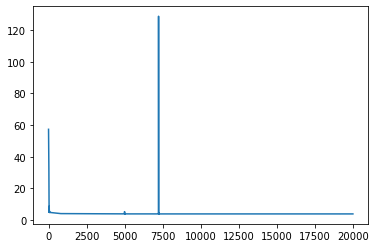

In [27]:
plt.plot(history.history['loss'])

In [28]:
res = model.predict([m1,m2,a],batch_size=n_dias)

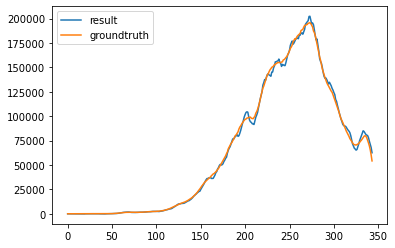

In [29]:
plt.plot(res[3:-3],label='result')
plt.plot(b[3:-3],label='groundtruth')
plt.legend()